# Implémentation de l'algorithme AIRL

In [6]:
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from imitation.algorithms.adversarial.airl import AIRL
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.data.rollout import generate_trajectories
from imitation.util.util import make_vec_env
from imitation.data.types import Transitions


In [ ]:
# Paramètres généraux
SEED = 42
ENV_NAME = "seals:seals/CartPole-v0"
N_TRAIN_STEPS = 100000  # Nombre d'étapes d'entraînement


In [ ]:
# Création d'un environnement vectorisé
env = make_vec_env(ENV_NAME, n_envs=1, rng=np.random.default_rng(SEED))

# Chargement d'une politique PPO pour servir de démonstrateur
expert = PPO(
    env=env,
    policy=MlpPolicy,
    batch_size=64,
    ent_coef=0.01,
    learning_rate=0.0003,
    gamma=0.99,
    seed=SEED,
)
expert.learn(total_timesteps=200_000)





In [9]:
from imitation.data.rollout import generate_trajectories, make_sample_until
import numpy as np

# Définir un générateur de nombres aléatoires
rng = np.random.default_rng(42)  # 42 est une graine arbitraire pour reproduire les résultats

# Collecte de trajectoires
trajectories = generate_trajectories(
    policy=expert,
    venv=env,  # Environnement vectorisé
    sample_until=make_sample_until(min_episodes=50),
    rng=rng,  # Ajout du générateur aléatoire
)


In [10]:
from imitation.data.types import Transitions
import numpy as np

# Conversion des trajectoires
observations = []
actions = []
next_observations = []
dones = []
infos = []

for traj in trajectories:
    observations.extend(traj.obs[:-1])  # Toutes les observations sauf la dernière
    actions.extend(traj.acts)          # Toutes les actions
    next_observations.extend(traj.obs[1:])  # Toutes les observations sauf la première
    dones.extend([False] * (len(traj.acts) - 1) + [True])  # Dernière action marque la fin
    infos.extend([{}] * len(traj.acts))  # Dictionnaires vides pour les métadonnées

# Création de l'objet Transitions
expert_data = Transitions(
    obs=np.array(observations),
    acts=np.array(actions),
    next_obs=np.array(next_observations),
    dones=np.array(dones),
    infos=np.array(infos, dtype=object),  # Nécessaire pour des objets complexes
)


In [11]:
# Réseau de récompense pour le discriminateur
reward_net = BasicRewardNet(
    observation_space=env.observation_space,
    action_space=env.action_space,
)

# Algorithme AIRL avec un PPO pour l'apprenant
learner = PPO(
    env=env,
    policy=MlpPolicy,
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0005,
    gamma=0.95,
    seed=SEED,
)
airl = AIRL(
    demonstrations=expert_data,
    gen_algo=learner,
    reward_net=reward_net,
    demo_batch_size=128,
    n_disc_updates_per_round=4,
    gen_replay_buffer_capacity=256,
    venv=env,
)


In [12]:
# Évaluation de la politique de l'apprenant avant l'entraînement
learner_rewards_before, _ = evaluate_policy(
    learner, env, n_eval_episodes=20, return_episode_rewards=True
)
print(f"Récompenses avant entraînement : {np.mean(learner_rewards_before):.2f}")


Récompenses avant entraînement : 116.35


In [13]:
import matplotlib.pyplot as plt
def plot_rewards(rewards, title="Récompenses par épisode"):
    """
    Trace les récompenses obtenues par épisode.

    :param rewards: Liste des récompenses obtenues lors de l'évaluation.
    :param title: Titre du graphique.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(rewards, marker='o', linestyle='-', label="Récompenses")
    plt.axhline(np.mean(rewards), color='r', linestyle='--', label=f"Moyenne = {np.mean(rewards):.2f}")
    plt.title(title)
    plt.xlabel("Épisode")
    plt.ylabel("Récompense")
    plt.legend()
    plt.grid(True)
    plt.show()


Récompenses avant entraînement : 99.35


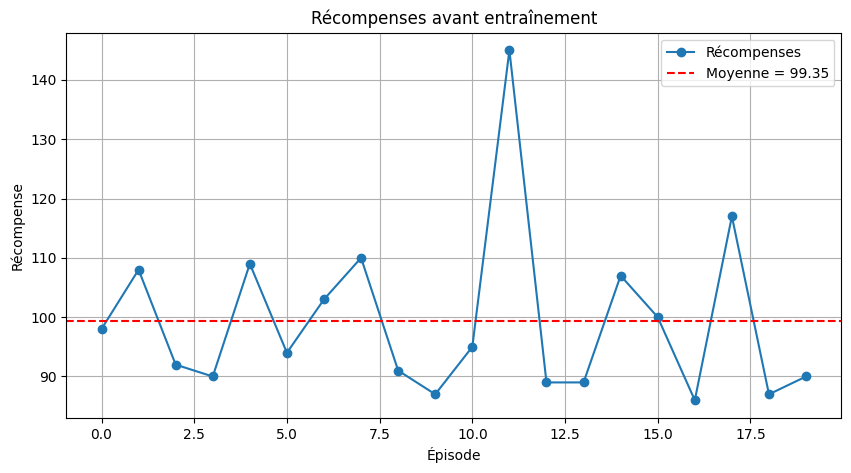

round:   0%|          | 0/244 [00:00<?, ?it/s]

------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 500      |
|    gen/rollout/ep_rew_mean  | 33       |
|    gen/time/fps             | 883      |
|    gen/time/iterations      | 1        |
|    gen/time/time_elapsed    | 2        |
|    gen/time/total_timesteps | 2048     |
------------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.546    |
|    disc/disc_loss                   | 1.13     |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 128      |
|    disc/n_generated                 | 128      |
-

round:   0%|          | 1/244 [00:03<15:31,  3.83s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 47.1         |
|    gen/rollout/ep_rew_wrapped_mean | 20.5         |
|    gen/time/fps                    | 787          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 4096         |
|    gen/train/approx_kl             | 0.0059323693 |
|    gen/train/clip_fraction         | 0.0333       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.688       |
|    gen/train/explained_variance    | -0.08155286  |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.746        |
|    gen/train/n_updates             | 10           |
|    gen/train/policy_gradient_loss  | -0.00159     |
|    gen/train/value_loss   

round:   1%|          | 2/244 [00:07<15:41,  3.89s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 45.2        |
|    gen/rollout/ep_rew_wrapped_mean | -35.9       |
|    gen/time/fps                    | 869         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 6144        |
|    gen/train/approx_kl             | 0.012022373 |
|    gen/train/clip_fraction         | 0.0926      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.686      |
|    gen/train/explained_variance    | 0.91664857  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0261      |
|    gen/train/n_updates             | 20          |
|    gen/train/policy_gradient_loss  | -0.00547    |
|    gen/train/value_loss            | 0.582  

round:   1%|          | 3/244 [00:11<15:13,  3.79s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 39.6        |
|    gen/rollout/ep_rew_wrapped_mean | -93.8       |
|    gen/time/fps                    | 879         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 8192        |
|    gen/train/approx_kl             | 0.006550288 |
|    gen/train/clip_fraction         | 0.0308      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.684      |
|    gen/train/explained_variance    | -0.05349052 |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.296       |
|    gen/train/n_updates             | 30          |
|    gen/train/policy_gradient_loss  | -0.00261    |
|    gen/train/value_loss            | 2.66   

round:   2%|▏         | 4/244 [00:14<14:48,  3.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 39.8         |
|    gen/rollout/ep_rew_wrapped_mean | -144         |
|    gen/time/fps                    | 883          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 10240        |
|    gen/train/approx_kl             | 0.0070469286 |
|    gen/train/clip_fraction         | 0.0133       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.679       |
|    gen/train/explained_variance    | 0.02369833   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.353        |
|    gen/train/n_updates             | 40           |
|    gen/train/policy_gradient_loss  | -0.00186     |
|    gen/train/value_loss   

round:   2%|▏         | 5/244 [00:18<14:37,  3.67s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 39.2        |
|    gen/rollout/ep_rew_wrapped_mean | -177        |
|    gen/time/fps                    | 883         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 12288       |
|    gen/train/approx_kl             | 0.011787601 |
|    gen/train/clip_fraction         | 0.0914      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.672      |
|    gen/train/explained_variance    | 0.29439533  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.285       |
|    gen/train/n_updates             | 50          |
|    gen/train/policy_gradient_loss  | -0.00482    |
|    gen/train/value_loss            | 2.49   

round:   2%|▏         | 6/244 [00:22<14:27,  3.64s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 39.6         |
|    gen/rollout/ep_rew_wrapped_mean | -259         |
|    gen/time/fps                    | 874          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 14336        |
|    gen/train/approx_kl             | 0.0036427584 |
|    gen/train/clip_fraction         | 0.0316       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.678       |
|    gen/train/explained_variance    | 0.41498816   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 1.73         |
|    gen/train/n_updates             | 60           |
|    gen/train/policy_gradient_loss  | -0.00248     |
|    gen/train/value_loss   

round:   3%|▎         | 7/244 [00:25<14:31,  3.68s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 39.2         |
|    gen/rollout/ep_rew_wrapped_mean | -310         |
|    gen/time/fps                    | 870          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 16384        |
|    gen/train/approx_kl             | 0.0071648397 |
|    gen/train/clip_fraction         | 0.0427       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.668       |
|    gen/train/explained_variance    | 0.7715343    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 3.99         |
|    gen/train/n_updates             | 70           |
|    gen/train/policy_gradient_loss  | -0.00585     |
|    gen/train/value_loss   

round:   3%|▎         | 8/244 [00:29<14:43,  3.75s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 37.6         |
|    gen/rollout/ep_rew_wrapped_mean | -340         |
|    gen/time/fps                    | 672          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 18432        |
|    gen/train/approx_kl             | 0.0029199221 |
|    gen/train/clip_fraction         | 0.0152       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.657       |
|    gen/train/explained_variance    | 0.79264677   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 3.7          |
|    gen/train/n_updates             | 80           |
|    gen/train/policy_gradient_loss  | -0.00124     |
|    gen/train/value_loss   

round:   4%|▎         | 9/244 [00:34<15:55,  4.06s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 36.6         |
|    gen/rollout/ep_rew_wrapped_mean | -353         |
|    gen/time/fps                    | 717          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 20480        |
|    gen/train/approx_kl             | 0.0072192578 |
|    gen/train/clip_fraction         | 0.0571       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.66        |
|    gen/train/explained_variance    | 0.9391976    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.174        |
|    gen/train/n_updates             | 90           |
|    gen/train/policy_gradient_loss  | -0.0051      |
|    gen/train/value_loss   

round:   4%|▍         | 10/244 [00:39<16:24,  4.21s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 36.7         |
|    gen/rollout/ep_rew_wrapped_mean | -398         |
|    gen/time/fps                    | 831          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 22528        |
|    gen/train/approx_kl             | 0.0036284607 |
|    gen/train/clip_fraction         | 0.0196       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.667       |
|    gen/train/explained_variance    | 0.95426166   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.786        |
|    gen/train/n_updates             | 100          |
|    gen/train/policy_gradient_loss  | -0.00321     |
|    gen/train/value_loss   

round:   5%|▍         | 11/244 [00:42<15:53,  4.09s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 37          |
|    gen/rollout/ep_rew_wrapped_mean | -437        |
|    gen/time/fps                    | 786         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 24576       |
|    gen/train/approx_kl             | 0.008650247 |
|    gen/train/clip_fraction         | 0.0709      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.651      |
|    gen/train/explained_variance    | 0.9765569   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.99        |
|    gen/train/n_updates             | 110         |
|    gen/train/policy_gradient_loss  | -0.0103     |
|    gen/train/value_loss            | 2.73   

round:   5%|▍         | 12/244 [00:46<15:43,  4.07s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 39          |
|    gen/rollout/ep_rew_wrapped_mean | -440        |
|    gen/time/fps                    | 799         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 26624       |
|    gen/train/approx_kl             | 0.010691635 |
|    gen/train/clip_fraction         | 0.0743      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.632      |
|    gen/train/explained_variance    | 0.97249115  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.556       |
|    gen/train/n_updates             | 120         |
|    gen/train/policy_gradient_loss  | -0.0129     |
|    gen/train/value_loss            | 1.3    

round:   5%|▌         | 13/244 [00:51<15:49,  4.11s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 39.6         |
|    gen/rollout/ep_rew_wrapped_mean | -445         |
|    gen/time/fps                    | 828          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 28672        |
|    gen/train/approx_kl             | 0.0064001624 |
|    gen/train/clip_fraction         | 0.0491       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.593       |
|    gen/train/explained_variance    | 0.97095895   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.422        |
|    gen/train/n_updates             | 130          |
|    gen/train/policy_gradient_loss  | -0.00656     |
|    gen/train/value_loss   

round:   6%|▌         | 14/244 [00:55<15:35,  4.07s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 39.7         |
|    gen/rollout/ep_rew_wrapped_mean | -441         |
|    gen/time/fps                    | 832          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 30720        |
|    gen/train/approx_kl             | 0.0072372495 |
|    gen/train/clip_fraction         | 0.0876       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.539       |
|    gen/train/explained_variance    | 0.9486632    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.178        |
|    gen/train/n_updates             | 140          |
|    gen/train/policy_gradient_loss  | -0.00496     |
|    gen/train/value_loss   

round:   6%|▌         | 15/244 [00:59<15:25,  4.04s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 39.5       |
|    gen/rollout/ep_rew_wrapped_mean | -439       |
|    gen/time/fps                    | 858        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 2          |
|    gen/time/total_timesteps        | 32768      |
|    gen/train/approx_kl             | 0.00795557 |
|    gen/train/clip_fraction         | 0.0973     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.531     |
|    gen/train/explained_variance    | 0.97571903 |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.0584     |
|    gen/train/n_updates             | 150        |
|    gen/train/policy_gradient_loss  | -0.00552   |
|    gen/train/value_loss            | 0.203      |
------------

round:   7%|▋         | 16/244 [01:03<15:09,  3.99s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 39.2        |
|    gen/rollout/ep_rew_wrapped_mean | -441        |
|    gen/time/fps                    | 782         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 34816       |
|    gen/train/approx_kl             | 0.012545974 |
|    gen/train/clip_fraction         | 0.14        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.564      |
|    gen/train/explained_variance    | 0.982535    |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0481      |
|    gen/train/n_updates             | 160         |
|    gen/train/policy_gradient_loss  | -0.0113     |
|    gen/train/value_loss            | 0.184  

round:   7%|▋         | 17/244 [01:07<15:21,  4.06s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 40.6        |
|    gen/rollout/ep_rew_wrapped_mean | -446        |
|    gen/time/fps                    | 690         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 36864       |
|    gen/train/approx_kl             | 0.010394413 |
|    gen/train/clip_fraction         | 0.14        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.568      |
|    gen/train/explained_variance    | 0.97260696  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0678      |
|    gen/train/n_updates             | 170         |
|    gen/train/policy_gradient_loss  | -0.0101     |
|    gen/train/value_loss            | 0.359  

round:   7%|▋         | 18/244 [01:11<15:51,  4.21s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 40.8         |
|    gen/rollout/ep_rew_wrapped_mean | -489         |
|    gen/time/fps                    | 675          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 38912        |
|    gen/train/approx_kl             | 0.0020648283 |
|    gen/train/clip_fraction         | 0.0281       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.551       |
|    gen/train/explained_variance    | 0.44594914   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 451          |
|    gen/train/n_updates             | 180          |
|    gen/train/policy_gradient_loss  | -0.0059      |
|    gen/train/value_loss   

round:   8%|▊         | 19/244 [01:16<16:08,  4.30s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 40.7        |
|    gen/rollout/ep_rew_wrapped_mean | -498        |
|    gen/time/fps                    | 796         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 40960       |
|    gen/train/approx_kl             | 0.009237818 |
|    gen/train/clip_fraction         | 0.115       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.574      |
|    gen/train/explained_variance    | 0.97952014  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.156       |
|    gen/train/n_updates             | 190         |
|    gen/train/policy_gradient_loss  | -0.0124     |
|    gen/train/value_loss            | 0.559  

round:   8%|▊         | 20/244 [01:20<15:40,  4.20s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 42.1        |
|    gen/rollout/ep_rew_wrapped_mean | -507        |
|    gen/time/fps                    | 789         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 43008       |
|    gen/train/approx_kl             | 0.011320297 |
|    gen/train/clip_fraction         | 0.164       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.588      |
|    gen/train/explained_variance    | 0.98610693  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.118       |
|    gen/train/n_updates             | 200         |
|    gen/train/policy_gradient_loss  | -0.0116     |
|    gen/train/value_loss            | 0.548  

round:   9%|▊         | 21/244 [01:24<15:43,  4.23s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 43.1       |
|    gen/rollout/ep_rew_wrapped_mean | -516       |
|    gen/time/fps                    | 675        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 45056      |
|    gen/train/approx_kl             | 0.01233075 |
|    gen/train/clip_fraction         | 0.117      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.588     |
|    gen/train/explained_variance    | 0.98431706 |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.161      |
|    gen/train/n_updates             | 210        |
|    gen/train/policy_gradient_loss  | -0.00547   |
|    gen/train/value_loss            | 0.487      |
------------

round:   9%|▉         | 22/244 [01:29<16:15,  4.40s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 45.5         |
|    gen/rollout/ep_rew_wrapped_mean | -558         |
|    gen/time/fps                    | 698          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 47104        |
|    gen/train/approx_kl             | 0.0044416348 |
|    gen/train/clip_fraction         | 0.0653       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.566       |
|    gen/train/explained_variance    | 0.60723287   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 274          |
|    gen/train/n_updates             | 220          |
|    gen/train/policy_gradient_loss  | -0.00298     |
|    gen/train/value_loss   

round:   9%|▉         | 23/244 [01:33<16:18,  4.43s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 47.1         |
|    gen/rollout/ep_rew_wrapped_mean | -565         |
|    gen/time/fps                    | 680          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 49152        |
|    gen/train/approx_kl             | 0.0075703925 |
|    gen/train/clip_fraction         | 0.0641       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.562       |
|    gen/train/explained_variance    | 0.9822188    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.223        |
|    gen/train/n_updates             | 230          |
|    gen/train/policy_gradient_loss  | -0.00597     |
|    gen/train/value_loss   

round:  10%|▉         | 24/244 [01:38<16:28,  4.49s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 49.9         |
|    gen/rollout/ep_rew_wrapped_mean | -612         |
|    gen/time/fps                    | 647          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 51200        |
|    gen/train/approx_kl             | 0.0037965141 |
|    gen/train/clip_fraction         | 0.0157       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.575       |
|    gen/train/explained_variance    | 0.8344374    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 156          |
|    gen/train/n_updates             | 240          |
|    gen/train/policy_gradient_loss  | -0.00203     |
|    gen/train/value_loss   

round:  10%|█         | 25/244 [01:43<16:49,  4.61s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 50.9         |
|    gen/rollout/ep_rew_wrapped_mean | -633         |
|    gen/time/fps                    | 676          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 53248        |
|    gen/train/approx_kl             | 0.0018413251 |
|    gen/train/clip_fraction         | 0.00923      |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.552       |
|    gen/train/explained_variance    | -0.94916594  |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.479        |
|    gen/train/n_updates             | 250          |
|    gen/train/policy_gradient_loss  | -0.00179     |
|    gen/train/value_loss   

round:  11%|█         | 26/244 [01:48<16:53,  4.65s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 52.2         |
|    gen/rollout/ep_rew_wrapped_mean | -697         |
|    gen/time/fps                    | 683          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 55296        |
|    gen/train/approx_kl             | 0.0032151146 |
|    gen/train/clip_fraction         | 0.0338       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.566       |
|    gen/train/explained_variance    | 0.7249726    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 271          |
|    gen/train/n_updates             | 260          |
|    gen/train/policy_gradient_loss  | -0.00469     |
|    gen/train/value_loss   

round:  11%|█         | 27/244 [01:52<16:54,  4.67s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 55.3        |
|    gen/rollout/ep_rew_wrapped_mean | -717        |
|    gen/time/fps                    | 786         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 57344       |
|    gen/train/approx_kl             | 0.011170016 |
|    gen/train/clip_fraction         | 0.107       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.523      |
|    gen/train/explained_variance    | 0.99428266  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0778      |
|    gen/train/n_updates             | 270         |
|    gen/train/policy_gradient_loss  | -0.0102     |
|    gen/train/value_loss            | 0.423  

round:  11%|█▏        | 28/244 [01:56<16:10,  4.49s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 56.5         |
|    gen/rollout/ep_rew_wrapped_mean | -738         |
|    gen/time/fps                    | 814          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 59392        |
|    gen/train/approx_kl             | 0.0069534136 |
|    gen/train/clip_fraction         | 0.0731       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.518       |
|    gen/train/explained_variance    | 0.9802581    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.168        |
|    gen/train/n_updates             | 280          |
|    gen/train/policy_gradient_loss  | -0.00654     |
|    gen/train/value_loss   

round:  12%|█▏        | 29/244 [02:00<15:34,  4.35s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 58.3       |
|    gen/rollout/ep_rew_wrapped_mean | -762       |
|    gen/time/fps                    | 774        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 2          |
|    gen/time/total_timesteps        | 61440      |
|    gen/train/approx_kl             | 0.00698503 |
|    gen/train/clip_fraction         | 0.0671     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.535     |
|    gen/train/explained_variance    | 0.74710095 |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 3.26       |
|    gen/train/n_updates             | 290        |
|    gen/train/policy_gradient_loss  | -0.00347   |
|    gen/train/value_loss            | 4.38       |
------------

round:  12%|█▏        | 30/244 [02:04<15:10,  4.26s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 62.7        |
|    gen/rollout/ep_rew_wrapped_mean | -773        |
|    gen/time/fps                    | 789         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 63488       |
|    gen/train/approx_kl             | 0.006998601 |
|    gen/train/clip_fraction         | 0.078       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.483      |
|    gen/train/explained_variance    | 0.9956019   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.123       |
|    gen/train/n_updates             | 300         |
|    gen/train/policy_gradient_loss  | -0.00462    |
|    gen/train/value_loss            | 0.408  

round:  13%|█▎        | 31/244 [02:09<15:05,  4.25s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 64.8         |
|    gen/rollout/ep_rew_wrapped_mean | -782         |
|    gen/time/fps                    | 729          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 65536        |
|    gen/train/approx_kl             | 0.0023249043 |
|    gen/train/clip_fraction         | 0.0256       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.485       |
|    gen/train/explained_variance    | 0.87470895   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.583        |
|    gen/train/n_updates             | 310          |
|    gen/train/policy_gradient_loss  | -0.000266    |
|    gen/train/value_loss   

round:  13%|█▎        | 32/244 [02:13<15:15,  4.32s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 67.2        |
|    gen/rollout/ep_rew_wrapped_mean | -808        |
|    gen/time/fps                    | 689         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 67584       |
|    gen/train/approx_kl             | 0.008871224 |
|    gen/train/clip_fraction         | 0.0861      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.504      |
|    gen/train/explained_variance    | 0.9726777   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.352       |
|    gen/train/n_updates             | 320         |
|    gen/train/policy_gradient_loss  | -0.00379    |
|    gen/train/value_loss            | 1.45   

round:  14%|█▎        | 33/244 [02:18<15:28,  4.40s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 69.5         |
|    gen/rollout/ep_rew_wrapped_mean | -894         |
|    gen/time/fps                    | 851          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 69632        |
|    gen/train/approx_kl             | 0.0049836924 |
|    gen/train/clip_fraction         | 0.016        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.536       |
|    gen/train/explained_variance    | 0.43104714   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 1.38e+03     |
|    gen/train/n_updates             | 330          |
|    gen/train/policy_gradient_loss  | -0.00276     |
|    gen/train/value_loss   

round:  14%|█▍        | 34/244 [02:22<14:56,  4.27s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 72.9        |
|    gen/rollout/ep_rew_wrapped_mean | -917        |
|    gen/time/fps                    | 842         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 71680       |
|    gen/train/approx_kl             | 0.005735157 |
|    gen/train/clip_fraction         | 0.0635      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.493      |
|    gen/train/explained_variance    | 0.95168734  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 16.1        |
|    gen/train/n_updates             | 340         |
|    gen/train/policy_gradient_loss  | -0.0124     |
|    gen/train/value_loss            | 45.4   

round:  14%|█▍        | 35/244 [02:26<14:30,  4.16s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 76.4         |
|    gen/rollout/ep_rew_wrapped_mean | -920         |
|    gen/time/fps                    | 753          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 73728        |
|    gen/train/approx_kl             | 0.0068392907 |
|    gen/train/clip_fraction         | 0.0842       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.473       |
|    gen/train/explained_variance    | 0.99207956   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.355        |
|    gen/train/n_updates             | 350          |
|    gen/train/policy_gradient_loss  | -0.00781     |
|    gen/train/value_loss   

round:  15%|█▍        | 36/244 [02:30<14:42,  4.24s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 78.2       |
|    gen/rollout/ep_rew_wrapped_mean | -931       |
|    gen/time/fps                    | 777        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 2          |
|    gen/time/total_timesteps        | 75776      |
|    gen/train/approx_kl             | 0.00820449 |
|    gen/train/clip_fraction         | 0.0735     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.451     |
|    gen/train/explained_variance    | 0.9963054  |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.285      |
|    gen/train/n_updates             | 360        |
|    gen/train/policy_gradient_loss  | -0.00631   |
|    gen/train/value_loss            | 0.815      |
------------

round:  15%|█▌        | 37/244 [02:34<14:29,  4.20s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 81.4         |
|    gen/rollout/ep_rew_wrapped_mean | -960         |
|    gen/time/fps                    | 784          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 77824        |
|    gen/train/approx_kl             | 0.0047782734 |
|    gen/train/clip_fraction         | 0.0609       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.441       |
|    gen/train/explained_variance    | 0.9971177    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.413        |
|    gen/train/n_updates             | 370          |
|    gen/train/policy_gradient_loss  | -0.00485     |
|    gen/train/value_loss   

round:  16%|█▌        | 38/244 [02:38<14:17,  4.16s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 81.8        |
|    gen/rollout/ep_rew_wrapped_mean | -977        |
|    gen/time/fps                    | 748         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 79872       |
|    gen/train/approx_kl             | 0.006391648 |
|    gen/train/clip_fraction         | 0.0714      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.421      |
|    gen/train/explained_variance    | 0.99662626  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.219       |
|    gen/train/n_updates             | 380         |
|    gen/train/policy_gradient_loss  | -0.00258    |
|    gen/train/value_loss            | 0.474  

round:  16%|█▌        | 39/244 [02:42<14:10,  4.15s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 83.9         |
|    gen/rollout/ep_rew_wrapped_mean | -998         |
|    gen/time/fps                    | 828          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 81920        |
|    gen/train/approx_kl             | 0.0066036885 |
|    gen/train/clip_fraction         | 0.0605       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.389       |
|    gen/train/explained_variance    | 0.9975888    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.139        |
|    gen/train/n_updates             | 390          |
|    gen/train/policy_gradient_loss  | -0.00566     |
|    gen/train/value_loss   

round:  16%|█▋        | 40/244 [02:46<13:59,  4.11s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 85.6         |
|    gen/rollout/ep_rew_wrapped_mean | -1.03e+03    |
|    gen/time/fps                    | 795          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 83968        |
|    gen/train/approx_kl             | 0.0062319105 |
|    gen/train/clip_fraction         | 0.0604       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.375       |
|    gen/train/explained_variance    | 0.99656177   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.101        |
|    gen/train/n_updates             | 400          |
|    gen/train/policy_gradient_loss  | -0.00425     |
|    gen/train/value_loss   

round:  17%|█▋        | 41/244 [02:51<13:57,  4.12s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 87.3         |
|    gen/rollout/ep_rew_wrapped_mean | -1.05e+03    |
|    gen/time/fps                    | 738          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 86016        |
|    gen/train/approx_kl             | 0.0064336117 |
|    gen/train/clip_fraction         | 0.0551       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.368       |
|    gen/train/explained_variance    | 0.9968432    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.305        |
|    gen/train/n_updates             | 410          |
|    gen/train/policy_gradient_loss  | -0.00362     |
|    gen/train/value_loss   

round:  17%|█▋        | 42/244 [02:55<14:17,  4.25s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 88.4        |
|    gen/rollout/ep_rew_wrapped_mean | -1.04e+03   |
|    gen/time/fps                    | 625         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 88064       |
|    gen/train/approx_kl             | 0.010334831 |
|    gen/train/clip_fraction         | 0.104       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.381      |
|    gen/train/explained_variance    | 0.99484974  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.215       |
|    gen/train/n_updates             | 420         |
|    gen/train/policy_gradient_loss  | -0.00312    |
|    gen/train/value_loss            | 0.635  

round:  18%|█▊        | 43/244 [03:01<16:04,  4.80s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 90.3         |
|    gen/rollout/ep_rew_wrapped_mean | -1.06e+03    |
|    gen/time/fps                    | 458          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 90112        |
|    gen/train/approx_kl             | 0.0045897476 |
|    gen/train/clip_fraction         | 0.0603       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.332       |
|    gen/train/explained_variance    | 0.9968399    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.128        |
|    gen/train/n_updates             | 430          |
|    gen/train/policy_gradient_loss  | -0.00285     |
|    gen/train/value_loss   

round:  18%|█▊        | 44/244 [03:08<18:14,  5.47s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 92.7        |
|    gen/rollout/ep_rew_wrapped_mean | -1.08e+03   |
|    gen/time/fps                    | 471         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 92160       |
|    gen/train/approx_kl             | 0.005870103 |
|    gen/train/clip_fraction         | 0.0554      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.387      |
|    gen/train/explained_variance    | 0.9935141   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.25        |
|    gen/train/n_updates             | 440         |
|    gen/train/policy_gradient_loss  | -0.00548    |
|    gen/train/value_loss            | 1.12   

round:  18%|█▊        | 45/244 [03:15<19:28,  5.87s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 93.8        |
|    gen/rollout/ep_rew_wrapped_mean | -1.1e+03    |
|    gen/time/fps                    | 468         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 94208       |
|    gen/train/approx_kl             | 0.005541398 |
|    gen/train/clip_fraction         | 0.0601      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.337      |
|    gen/train/explained_variance    | 0.9872304   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.224       |
|    gen/train/n_updates             | 450         |
|    gen/train/policy_gradient_loss  | -0.0043     |
|    gen/train/value_loss            | 1.78   

round:  19%|█▉        | 46/244 [03:22<20:00,  6.06s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 95.8        |
|    gen/rollout/ep_rew_wrapped_mean | -1.1e+03    |
|    gen/time/fps                    | 482         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 96256       |
|    gen/train/approx_kl             | 0.010354386 |
|    gen/train/clip_fraction         | 0.0788      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.385      |
|    gen/train/explained_variance    | 0.9927955   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.554       |
|    gen/train/n_updates             | 460         |
|    gen/train/policy_gradient_loss  | -0.00655    |
|    gen/train/value_loss            | 2.31   

round:  19%|█▉        | 47/244 [03:28<20:15,  6.17s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 98.1        |
|    gen/rollout/ep_rew_wrapped_mean | -1.12e+03   |
|    gen/time/fps                    | 462         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 98304       |
|    gen/train/approx_kl             | 0.005550626 |
|    gen/train/clip_fraction         | 0.0548      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.336      |
|    gen/train/explained_variance    | 0.9966557   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.279       |
|    gen/train/n_updates             | 470         |
|    gen/train/policy_gradient_loss  | -0.00328    |
|    gen/train/value_loss            | 1.42   

round:  20%|█▉        | 48/244 [03:34<20:13,  6.19s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 98.1       |
|    gen/rollout/ep_rew_wrapped_mean | -1.12e+03  |
|    gen/time/fps                    | 513        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 100352     |
|    gen/train/approx_kl             | 0.00924305 |
|    gen/train/clip_fraction         | 0.0896     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.363     |
|    gen/train/explained_variance    | 0.9968664  |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.416      |
|    gen/train/n_updates             | 480        |
|    gen/train/policy_gradient_loss  | -0.00499   |
|    gen/train/value_loss            | 1.18       |
------------

round:  20%|██        | 49/244 [03:40<20:09,  6.20s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 100          |
|    gen/rollout/ep_rew_wrapped_mean | -1.14e+03    |
|    gen/time/fps                    | 490          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 102400       |
|    gen/train/approx_kl             | 0.0040463908 |
|    gen/train/clip_fraction         | 0.0502       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.361       |
|    gen/train/explained_variance    | 0.99210864   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.621        |
|    gen/train/n_updates             | 490          |
|    gen/train/policy_gradient_loss  | -0.00308     |
|    gen/train/value_loss   

round:  20%|██        | 50/244 [03:47<20:08,  6.23s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 103         |
|    gen/rollout/ep_rew_wrapped_mean | -1.12e+03   |
|    gen/time/fps                    | 472         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 104448      |
|    gen/train/approx_kl             | 0.012226514 |
|    gen/train/clip_fraction         | 0.133       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.397      |
|    gen/train/explained_variance    | 0.99684995  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.565       |
|    gen/train/n_updates             | 500         |
|    gen/train/policy_gradient_loss  | -0.0117     |
|    gen/train/value_loss            | 1.96   

round:  21%|██        | 51/244 [03:53<20:01,  6.23s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 104         |
|    gen/rollout/ep_rew_wrapped_mean | -1.15e+03   |
|    gen/time/fps                    | 512         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 106496      |
|    gen/train/approx_kl             | 0.010490282 |
|    gen/train/clip_fraction         | 0.0952      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.425      |
|    gen/train/explained_variance    | 0.9966044   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 1.19        |
|    gen/train/n_updates             | 510         |
|    gen/train/policy_gradient_loss  | -0.0103     |
|    gen/train/value_loss            | 2.24   

round:  21%|██▏       | 52/244 [03:59<19:29,  6.09s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 109         |
|    gen/rollout/ep_rew_wrapped_mean | -1.2e+03    |
|    gen/time/fps                    | 570         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 108544      |
|    gen/train/approx_kl             | 0.009060716 |
|    gen/train/clip_fraction         | 0.0946      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.473      |
|    gen/train/explained_variance    | 0.9941269   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 2.3         |
|    gen/train/n_updates             | 520         |
|    gen/train/policy_gradient_loss  | -0.00242    |
|    gen/train/value_loss            | 5.13   

round:  22%|██▏       | 53/244 [04:03<18:03,  5.67s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 113         |
|    gen/rollout/ep_rew_wrapped_mean | -1.23e+03   |
|    gen/time/fps                    | 687         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 110592      |
|    gen/train/approx_kl             | 0.010864411 |
|    gen/train/clip_fraction         | 0.101       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.43       |
|    gen/train/explained_variance    | 0.9977692   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.962       |
|    gen/train/n_updates             | 530         |
|    gen/train/policy_gradient_loss  | -0.00648    |
|    gen/train/value_loss            | 1.83   

round:  22%|██▏       | 54/244 [04:08<16:37,  5.25s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 119          |
|    gen/rollout/ep_rew_wrapped_mean | -1.27e+03    |
|    gen/time/fps                    | 824          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 112640       |
|    gen/train/approx_kl             | 0.0050357394 |
|    gen/train/clip_fraction         | 0.0537       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.41        |
|    gen/train/explained_variance    | 0.9974931    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 1.01         |
|    gen/train/n_updates             | 540          |
|    gen/train/policy_gradient_loss  | -0.00401     |
|    gen/train/value_loss   

round:  23%|██▎       | 55/244 [04:11<15:03,  4.78s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 121         |
|    gen/rollout/ep_rew_wrapped_mean | -1.27e+03   |
|    gen/time/fps                    | 925         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 114688      |
|    gen/train/approx_kl             | 0.006705586 |
|    gen/train/clip_fraction         | 0.092       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.371      |
|    gen/train/explained_variance    | 0.9961221   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.689       |
|    gen/train/n_updates             | 550         |
|    gen/train/policy_gradient_loss  | -0.00534    |
|    gen/train/value_loss            | 2.12   

round:  23%|██▎       | 56/244 [04:16<14:50,  4.74s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 125         |
|    gen/rollout/ep_rew_wrapped_mean | -1.3e+03    |
|    gen/time/fps                    | 333         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 6           |
|    gen/time/total_timesteps        | 116736      |
|    gen/train/approx_kl             | 0.005324331 |
|    gen/train/clip_fraction         | 0.0621      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.404      |
|    gen/train/explained_variance    | 0.9974345   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.621       |
|    gen/train/n_updates             | 560         |
|    gen/train/policy_gradient_loss  | -0.00322    |
|    gen/train/value_loss            | 2.29   

round:  23%|██▎       | 57/244 [04:26<19:33,  6.28s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 128          |
|    gen/rollout/ep_rew_wrapped_mean | -1.3e+03     |
|    gen/time/fps                    | 291          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 7            |
|    gen/time/total_timesteps        | 118784       |
|    gen/train/approx_kl             | 0.0039026092 |
|    gen/train/clip_fraction         | 0.0463       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.389       |
|    gen/train/explained_variance    | 0.9972727    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.757        |
|    gen/train/n_updates             | 570          |
|    gen/train/policy_gradient_loss  | -0.00601     |
|    gen/train/value_loss   

round:  24%|██▍       | 58/244 [04:36<23:29,  7.58s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 130         |
|    gen/rollout/ep_rew_wrapped_mean | -1.28e+03   |
|    gen/time/fps                    | 518         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 120832      |
|    gen/train/approx_kl             | 0.007970911 |
|    gen/train/clip_fraction         | 0.0899      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.47       |
|    gen/train/explained_variance    | 0.99731123  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 2.21        |
|    gen/train/n_updates             | 580         |
|    gen/train/policy_gradient_loss  | -0.00555    |
|    gen/train/value_loss            | 4.78   

round:  24%|██▍       | 59/244 [04:43<21:59,  7.13s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 133         |
|    gen/rollout/ep_rew_wrapped_mean | -1.32e+03   |
|    gen/time/fps                    | 696         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 122880      |
|    gen/train/approx_kl             | 0.007827178 |
|    gen/train/clip_fraction         | 0.0753      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.433      |
|    gen/train/explained_variance    | 0.99770653  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.805       |
|    gen/train/n_updates             | 590         |
|    gen/train/policy_gradient_loss  | -0.00443    |
|    gen/train/value_loss            | 3.49   

round:  25%|██▍       | 60/244 [04:47<19:25,  6.34s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 136          |
|    gen/rollout/ep_rew_wrapped_mean | -1.37e+03    |
|    gen/time/fps                    | 690          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 124928       |
|    gen/train/approx_kl             | 0.0069865873 |
|    gen/train/clip_fraction         | 0.0835       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.387       |
|    gen/train/explained_variance    | 0.9975995    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.825        |
|    gen/train/n_updates             | 600          |
|    gen/train/policy_gradient_loss  | -0.0058      |
|    gen/train/value_loss   

round:  25%|██▌       | 61/244 [04:52<17:43,  5.81s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 144         |
|    gen/rollout/ep_rew_wrapped_mean | -1.39e+03   |
|    gen/time/fps                    | 850         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 126976      |
|    gen/train/approx_kl             | 0.007242061 |
|    gen/train/clip_fraction         | 0.075       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.335      |
|    gen/train/explained_variance    | 0.9975911   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.702       |
|    gen/train/n_updates             | 610         |
|    gen/train/policy_gradient_loss  | -0.00535    |
|    gen/train/value_loss            | 2.17   

round:  25%|██▌       | 62/244 [04:55<15:49,  5.22s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 153         |
|    gen/rollout/ep_rew_wrapped_mean | -1.39e+03   |
|    gen/time/fps                    | 884         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 129024      |
|    gen/train/approx_kl             | 0.006086929 |
|    gen/train/clip_fraction         | 0.0772      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.357      |
|    gen/train/explained_variance    | 0.99715155  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.428       |
|    gen/train/n_updates             | 620         |
|    gen/train/policy_gradient_loss  | -0.00585    |
|    gen/train/value_loss            | 2.76   

round:  26%|██▌       | 63/244 [04:59<14:21,  4.76s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 163         |
|    gen/rollout/ep_rew_wrapped_mean | -1.41e+03   |
|    gen/time/fps                    | 875         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 131072      |
|    gen/train/approx_kl             | 0.012777604 |
|    gen/train/clip_fraction         | 0.078       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.388      |
|    gen/train/explained_variance    | 0.99790984  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.69        |
|    gen/train/n_updates             | 630         |
|    gen/train/policy_gradient_loss  | -0.00772    |
|    gen/train/value_loss            | 2.2    

round:  26%|██▌       | 64/244 [05:03<13:17,  4.43s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 173          |
|    gen/rollout/ep_rew_wrapped_mean | -1.4e+03     |
|    gen/time/fps                    | 871          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 133120       |
|    gen/train/approx_kl             | 0.0058981497 |
|    gen/train/clip_fraction         | 0.0552       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.342       |
|    gen/train/explained_variance    | 0.9974343    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 1.1          |
|    gen/train/n_updates             | 640          |
|    gen/train/policy_gradient_loss  | -0.00193     |
|    gen/train/value_loss   

round:  27%|██▋       | 65/244 [05:07<12:38,  4.24s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 183          |
|    gen/rollout/ep_rew_wrapped_mean | -1.4e+03     |
|    gen/time/fps                    | 914          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 135168       |
|    gen/train/approx_kl             | 0.0054473514 |
|    gen/train/clip_fraction         | 0.057        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.357       |
|    gen/train/explained_variance    | 0.9945718    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.761        |
|    gen/train/n_updates             | 650          |
|    gen/train/policy_gradient_loss  | -0.0063      |
|    gen/train/value_loss   

round:  27%|██▋       | 66/244 [05:10<11:59,  4.04s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 197         |
|    gen/rollout/ep_rew_wrapped_mean | -1.4e+03    |
|    gen/time/fps                    | 880         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 137216      |
|    gen/train/approx_kl             | 0.005511051 |
|    gen/train/clip_fraction         | 0.0486      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.355      |
|    gen/train/explained_variance    | 0.9968793   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 1.29        |
|    gen/train/n_updates             | 660         |
|    gen/train/policy_gradient_loss  | -0.00539    |
|    gen/train/value_loss            | 3.14   

round:  27%|██▋       | 67/244 [05:14<11:41,  3.96s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 210         |
|    gen/rollout/ep_rew_wrapped_mean | -1.37e+03   |
|    gen/time/fps                    | 776         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 139264      |
|    gen/train/approx_kl             | 0.008148658 |
|    gen/train/clip_fraction         | 0.0738      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.328      |
|    gen/train/explained_variance    | 0.99592525  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 1.07        |
|    gen/train/n_updates             | 670         |
|    gen/train/policy_gradient_loss  | -0.00483    |
|    gen/train/value_loss            | 3.85   

round:  28%|██▊       | 68/244 [05:18<11:47,  4.02s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 224         |
|    gen/rollout/ep_rew_wrapped_mean | -1.36e+03   |
|    gen/time/fps                    | 830         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 141312      |
|    gen/train/approx_kl             | 0.009061733 |
|    gen/train/clip_fraction         | 0.0814      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.346      |
|    gen/train/explained_variance    | 0.99787414  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.344       |
|    gen/train/n_updates             | 680         |
|    gen/train/policy_gradient_loss  | -0.00543    |
|    gen/train/value_loss            | 2.33   

round:  28%|██▊       | 69/244 [05:22<11:41,  4.01s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 236         |
|    gen/rollout/ep_rew_wrapped_mean | -1.35e+03   |
|    gen/time/fps                    | 887         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 143360      |
|    gen/train/approx_kl             | 0.005715072 |
|    gen/train/clip_fraction         | 0.053       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.322      |
|    gen/train/explained_variance    | 0.995507    |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.243       |
|    gen/train/n_updates             | 690         |
|    gen/train/policy_gradient_loss  | -0.00259    |
|    gen/train/value_loss            | 5.58   

round:  29%|██▊       | 70/244 [05:26<11:23,  3.93s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 249          |
|    gen/rollout/ep_rew_wrapped_mean | -1.34e+03    |
|    gen/time/fps                    | 888          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 145408       |
|    gen/train/approx_kl             | 0.0034693298 |
|    gen/train/clip_fraction         | 0.0315       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.344       |
|    gen/train/explained_variance    | 0.96427643   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 22.2         |
|    gen/train/n_updates             | 700          |
|    gen/train/policy_gradient_loss  | -0.0012      |
|    gen/train/value_loss   

round:  29%|██▉       | 71/244 [05:29<11:02,  3.83s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 264         |
|    gen/rollout/ep_rew_wrapped_mean | -1.3e+03    |
|    gen/time/fps                    | 903         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 147456      |
|    gen/train/approx_kl             | 0.007407223 |
|    gen/train/clip_fraction         | 0.0898      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.277      |
|    gen/train/explained_variance    | 0.997309    |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.369       |
|    gen/train/n_updates             | 710         |
|    gen/train/policy_gradient_loss  | -0.00421    |
|    gen/train/value_loss            | 1.05   

round:  30%|██▉       | 72/244 [05:33<10:49,  3.77s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 283          |
|    gen/rollout/ep_rew_wrapped_mean | -1.26e+03    |
|    gen/time/fps                    | 835          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 149504       |
|    gen/train/approx_kl             | 0.0037128672 |
|    gen/train/clip_fraction         | 0.0366       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.242       |
|    gen/train/explained_variance    | 0.9782532    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.25         |
|    gen/train/n_updates             | 720          |
|    gen/train/policy_gradient_loss  | -0.00114     |
|    gen/train/value_loss   

round:  30%|██▉       | 73/244 [05:37<11:09,  3.92s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 298        |
|    gen/rollout/ep_rew_wrapped_mean | -1.21e+03  |
|    gen/time/fps                    | 834        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 2          |
|    gen/time/total_timesteps        | 151552     |
|    gen/train/approx_kl             | 0.00711577 |
|    gen/train/clip_fraction         | 0.061      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.22      |
|    gen/train/explained_variance    | 0.9737029  |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.305      |
|    gen/train/n_updates             | 730        |
|    gen/train/policy_gradient_loss  | -0.0039    |
|    gen/train/value_loss            | 0.672      |
------------

round:  30%|███       | 74/244 [05:41<11:01,  3.89s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 312          |
|    gen/rollout/ep_rew_wrapped_mean | -1.16e+03    |
|    gen/time/fps                    | 895          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 153600       |
|    gen/train/approx_kl             | 0.0060166763 |
|    gen/train/clip_fraction         | 0.0369       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.212       |
|    gen/train/explained_variance    | 0.96551704   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.107        |
|    gen/train/n_updates             | 740          |
|    gen/train/policy_gradient_loss  | -0.00189     |
|    gen/train/value_loss   

round:  31%|███       | 75/244 [05:45<10:50,  3.85s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 326          |
|    gen/rollout/ep_rew_wrapped_mean | -1.11e+03    |
|    gen/time/fps                    | 922          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 155648       |
|    gen/train/approx_kl             | 0.0037020063 |
|    gen/train/clip_fraction         | 0.0409       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.211       |
|    gen/train/explained_variance    | 0.975785     |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.118        |
|    gen/train/n_updates             | 750          |
|    gen/train/policy_gradient_loss  | -0.00531     |
|    gen/train/value_loss   

round:  31%|███       | 76/244 [05:49<10:37,  3.79s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 340         |
|    gen/rollout/ep_rew_wrapped_mean | -1.05e+03   |
|    gen/time/fps                    | 906         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 157696      |
|    gen/train/approx_kl             | 0.006753265 |
|    gen/train/clip_fraction         | 0.0608      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.22       |
|    gen/train/explained_variance    | 0.9891789   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.889       |
|    gen/train/n_updates             | 760         |
|    gen/train/policy_gradient_loss  | 0.00472     |
|    gen/train/value_loss            | 1.21   

round:  32%|███▏      | 77/244 [05:52<10:27,  3.76s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 352          |
|    gen/rollout/ep_rew_wrapped_mean | -997         |
|    gen/time/fps                    | 851          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 159744       |
|    gen/train/approx_kl             | 0.0012594712 |
|    gen/train/clip_fraction         | 0.0297       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.192       |
|    gen/train/explained_variance    | 0.98785734   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.248        |
|    gen/train/n_updates             | 770          |
|    gen/train/policy_gradient_loss  | -0.00116     |
|    gen/train/value_loss   

round:  32%|███▏      | 78/244 [05:56<10:23,  3.76s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 363          |
|    gen/rollout/ep_rew_wrapped_mean | -941         |
|    gen/time/fps                    | 840          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 161792       |
|    gen/train/approx_kl             | 0.0025018468 |
|    gen/train/clip_fraction         | 0.0479       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.205       |
|    gen/train/explained_variance    | 0.99854964   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.205        |
|    gen/train/n_updates             | 780          |
|    gen/train/policy_gradient_loss  | -0.000146    |
|    gen/train/value_loss   

round:  32%|███▏      | 79/244 [06:00<10:31,  3.83s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 376          |
|    gen/rollout/ep_rew_wrapped_mean | -897         |
|    gen/time/fps                    | 830          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 163840       |
|    gen/train/approx_kl             | 0.0017049286 |
|    gen/train/clip_fraction         | 0.0514       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.207       |
|    gen/train/explained_variance    | 0.9949391    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.177        |
|    gen/train/n_updates             | 790          |
|    gen/train/policy_gradient_loss  | -0.000356    |
|    gen/train/value_loss   

round:  33%|███▎      | 80/244 [06:04<10:37,  3.89s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 389          |
|    gen/rollout/ep_rew_wrapped_mean | -852         |
|    gen/time/fps                    | 632          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 165888       |
|    gen/train/approx_kl             | 0.0027556596 |
|    gen/train/clip_fraction         | 0.0336       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.205       |
|    gen/train/explained_variance    | 0.98830837   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.121        |
|    gen/train/n_updates             | 800          |
|    gen/train/policy_gradient_loss  | -0.00287     |
|    gen/train/value_loss   

round:  33%|███▎      | 81/244 [06:09<11:15,  4.15s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 401         |
|    gen/rollout/ep_rew_wrapped_mean | -808        |
|    gen/time/fps                    | 860         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 167936      |
|    gen/train/approx_kl             | 0.004107475 |
|    gen/train/clip_fraction         | 0.0645      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.214      |
|    gen/train/explained_variance    | 0.9974227   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.065       |
|    gen/train/n_updates             | 810         |
|    gen/train/policy_gradient_loss  | -0.00353    |
|    gen/train/value_loss            | 0.29   

round:  34%|███▎      | 82/244 [06:12<10:48,  4.00s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 415         |
|    gen/rollout/ep_rew_wrapped_mean | -742        |
|    gen/time/fps                    | 798         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 169984      |
|    gen/train/approx_kl             | 0.004631677 |
|    gen/train/clip_fraction         | 0.0246      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.192      |
|    gen/train/explained_variance    | 0.9785638   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.188       |
|    gen/train/n_updates             | 820         |
|    gen/train/policy_gradient_loss  | -0.00249    |
|    gen/train/value_loss            | 0.29   

round:  34%|███▍      | 83/244 [06:16<10:38,  3.97s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 431          |
|    gen/rollout/ep_rew_wrapped_mean | -661         |
|    gen/time/fps                    | 937          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 172032       |
|    gen/train/approx_kl             | 0.0037432648 |
|    gen/train/clip_fraction         | 0.0548       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.195       |
|    gen/train/explained_variance    | 0.9801723    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.145        |
|    gen/train/n_updates             | 830          |
|    gen/train/policy_gradient_loss  | -0.00452     |
|    gen/train/value_loss   

round:  34%|███▍      | 84/244 [06:20<10:06,  3.79s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 442          |
|    gen/rollout/ep_rew_wrapped_mean | -575         |
|    gen/time/fps                    | 930          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 174080       |
|    gen/train/approx_kl             | 0.0055859364 |
|    gen/train/clip_fraction         | 0.0657       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.217       |
|    gen/train/explained_variance    | 0.99690354   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.129        |
|    gen/train/n_updates             | 840          |
|    gen/train/policy_gradient_loss  | -0.00208     |
|    gen/train/value_loss   

round:  35%|███▍      | 85/244 [06:23<09:51,  3.72s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 452          |
|    gen/rollout/ep_rew_wrapped_mean | -525         |
|    gen/time/fps                    | 926          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 176128       |
|    gen/train/approx_kl             | 0.0062905485 |
|    gen/train/clip_fraction         | 0.0292       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.213       |
|    gen/train/explained_variance    | 0.99547476   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0967       |
|    gen/train/n_updates             | 850          |
|    gen/train/policy_gradient_loss  | -0.00171     |
|    gen/train/value_loss   

round:  35%|███▌      | 86/244 [06:27<09:37,  3.65s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 460          |
|    gen/rollout/ep_rew_wrapped_mean | -478         |
|    gen/time/fps                    | 937          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 178176       |
|    gen/train/approx_kl             | 0.0031875758 |
|    gen/train/clip_fraction         | 0.0376       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.178       |
|    gen/train/explained_variance    | 0.9665735    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.235        |
|    gen/train/n_updates             | 860          |
|    gen/train/policy_gradient_loss  | -0.00167     |
|    gen/train/value_loss   

round:  36%|███▌      | 87/244 [06:30<09:31,  3.64s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 469         |
|    gen/rollout/ep_rew_wrapped_mean | -434        |
|    gen/time/fps                    | 761         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 180224      |
|    gen/train/approx_kl             | 0.004333167 |
|    gen/train/clip_fraction         | 0.0447      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.17       |
|    gen/train/explained_variance    | 0.9359007   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.292       |
|    gen/train/n_updates             | 870         |
|    gen/train/policy_gradient_loss  | -0.00282    |
|    gen/train/value_loss            | 0.406  

round:  36%|███▌      | 88/244 [06:35<09:57,  3.83s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 500           |
|    gen/rollout/ep_rew_mean         | 475           |
|    gen/rollout/ep_rew_wrapped_mean | -398          |
|    gen/time/fps                    | 651           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 3             |
|    gen/time/total_timesteps        | 182272        |
|    gen/train/approx_kl             | 0.00086643413 |
|    gen/train/clip_fraction         | 0.0282        |
|    gen/train/clip_range            | 0.2           |
|    gen/train/entropy_loss          | -0.183        |
|    gen/train/explained_variance    | 0.8393645     |
|    gen/train/learning_rate         | 0.0005        |
|    gen/train/loss                  | 0.222         |
|    gen/train/n_updates             | 880           |
|    gen/train/policy_gradient_loss  | 0.000321      |
|    gen/t

round:  36%|███▋      | 89/244 [06:40<10:44,  4.16s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 481          |
|    gen/rollout/ep_rew_wrapped_mean | -365         |
|    gen/time/fps                    | 748          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 184320       |
|    gen/train/approx_kl             | 0.0049941917 |
|    gen/train/clip_fraction         | 0.0324       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.217       |
|    gen/train/explained_variance    | 0.9721378    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0981       |
|    gen/train/n_updates             | 890          |
|    gen/train/policy_gradient_loss  | -0.00191     |
|    gen/train/value_loss   

round:  37%|███▋      | 90/244 [06:44<10:50,  4.23s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 500           |
|    gen/rollout/ep_rew_mean         | 487           |
|    gen/rollout/ep_rew_wrapped_mean | -338          |
|    gen/time/fps                    | 803           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 2             |
|    gen/time/total_timesteps        | 186368        |
|    gen/train/approx_kl             | 0.00064458966 |
|    gen/train/clip_fraction         | 0.0197        |
|    gen/train/clip_range            | 0.2           |
|    gen/train/entropy_loss          | -0.211        |
|    gen/train/explained_variance    | 0.94586974    |
|    gen/train/learning_rate         | 0.0005        |
|    gen/train/loss                  | 0.0551        |
|    gen/train/n_updates             | 900           |
|    gen/train/policy_gradient_loss  | 0.00024       |
|    gen/t

round:  37%|███▋      | 91/244 [06:48<10:33,  4.14s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 491         |
|    gen/rollout/ep_rew_wrapped_mean | -303        |
|    gen/time/fps                    | 741         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 188416      |
|    gen/train/approx_kl             | 0.004470353 |
|    gen/train/clip_fraction         | 0.0512      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.222      |
|    gen/train/explained_variance    | 0.94030005  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.022       |
|    gen/train/n_updates             | 910         |
|    gen/train/policy_gradient_loss  | -0.00229    |
|    gen/train/value_loss            | 0.251  

round:  38%|███▊      | 92/244 [06:52<10:44,  4.24s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 493          |
|    gen/rollout/ep_rew_wrapped_mean | -285         |
|    gen/time/fps                    | 695          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 190464       |
|    gen/train/approx_kl             | 0.0024919715 |
|    gen/train/clip_fraction         | 0.0237       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.22        |
|    gen/train/explained_variance    | 0.97738045   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0625       |
|    gen/train/n_updates             | 920          |
|    gen/train/policy_gradient_loss  | -0.00173     |
|    gen/train/value_loss   

round:  38%|███▊      | 93/244 [06:57<11:02,  4.39s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 495          |
|    gen/rollout/ep_rew_wrapped_mean | -262         |
|    gen/time/fps                    | 641          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 192512       |
|    gen/train/approx_kl             | 0.0021016197 |
|    gen/train/clip_fraction         | 0.0243       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.186       |
|    gen/train/explained_variance    | 0.82834697   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0839       |
|    gen/train/n_updates             | 930          |
|    gen/train/policy_gradient_loss  | 0.000255     |
|    gen/train/value_loss   

round:  39%|███▊      | 94/244 [07:02<11:26,  4.57s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 499          |
|    gen/rollout/ep_rew_wrapped_mean | -240         |
|    gen/time/fps                    | 764          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 194560       |
|    gen/train/approx_kl             | 0.0027527518 |
|    gen/train/clip_fraction         | 0.0522       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.207       |
|    gen/train/explained_variance    | 0.97674125   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.167        |
|    gen/train/n_updates             | 940          |
|    gen/train/policy_gradient_loss  | -0.00177     |
|    gen/train/value_loss   

round:  39%|███▉      | 95/244 [07:06<11:07,  4.48s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 499          |
|    gen/rollout/ep_rew_wrapped_mean | -204         |
|    gen/time/fps                    | 804          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 196608       |
|    gen/train/approx_kl             | 0.0027082786 |
|    gen/train/clip_fraction         | 0.0398       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.243       |
|    gen/train/explained_variance    | 0.9559388    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0283       |
|    gen/train/n_updates             | 950          |
|    gen/train/policy_gradient_loss  | -0.00293     |
|    gen/train/value_loss   

round:  39%|███▉      | 96/244 [07:11<10:48,  4.38s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 499         |
|    gen/rollout/ep_rew_wrapped_mean | -199        |
|    gen/time/fps                    | 773         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 198656      |
|    gen/train/approx_kl             | 0.004097334 |
|    gen/train/clip_fraction         | 0.0455      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.206      |
|    gen/train/explained_variance    | 0.95731556  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0692      |
|    gen/train/n_updates             | 960         |
|    gen/train/policy_gradient_loss  | -0.00204    |
|    gen/train/value_loss            | 0.136  

round:  40%|███▉      | 97/244 [07:15<10:40,  4.36s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 499          |
|    gen/rollout/ep_rew_wrapped_mean | -192         |
|    gen/time/fps                    | 745          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 200704       |
|    gen/train/approx_kl             | 0.0014173257 |
|    gen/train/clip_fraction         | 0.0387       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.204       |
|    gen/train/explained_variance    | 0.95157105   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.327        |
|    gen/train/n_updates             | 970          |
|    gen/train/policy_gradient_loss  | -0.00027     |
|    gen/train/value_loss   

round:  40%|████      | 98/244 [07:20<11:06,  4.57s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 499         |
|    gen/rollout/ep_rew_wrapped_mean | -188        |
|    gen/time/fps                    | 408         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 5           |
|    gen/time/total_timesteps        | 202752      |
|    gen/train/approx_kl             | 0.008646552 |
|    gen/train/clip_fraction         | 0.0525      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.204      |
|    gen/train/explained_variance    | 0.9481622   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0614      |
|    gen/train/n_updates             | 980         |
|    gen/train/policy_gradient_loss  | -0.00179    |
|    gen/train/value_loss            | 0.168  

round:  41%|████      | 99/244 [07:28<13:15,  5.49s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -186         |
|    gen/time/fps                    | 447          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 204800       |
|    gen/train/approx_kl             | 0.0018222043 |
|    gen/train/clip_fraction         | 0.0316       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.227       |
|    gen/train/explained_variance    | 0.89666843   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0996       |
|    gen/train/n_updates             | 990          |
|    gen/train/policy_gradient_loss  | -0.00212     |
|    gen/train/value_loss   

round:  41%|████      | 100/244 [07:34<14:05,  5.87s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -177         |
|    gen/time/fps                    | 468          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 206848       |
|    gen/train/approx_kl             | 0.0043764114 |
|    gen/train/clip_fraction         | 0.0483       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.206       |
|    gen/train/explained_variance    | 0.99097335   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.045        |
|    gen/train/n_updates             | 1000         |
|    gen/train/policy_gradient_loss  | -0.00222     |
|    gen/train/value_loss   

round:  41%|████▏     | 101/244 [07:41<14:38,  6.14s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -168         |
|    gen/time/fps                    | 432          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 208896       |
|    gen/train/approx_kl             | 0.0021813693 |
|    gen/train/clip_fraction         | 0.0383       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.219       |
|    gen/train/explained_variance    | 0.96770704   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0331       |
|    gen/train/n_updates             | 1010         |
|    gen/train/policy_gradient_loss  | -0.00192     |
|    gen/train/value_loss   

round:  42%|████▏     | 102/244 [07:48<15:04,  6.37s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -158         |
|    gen/time/fps                    | 425          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 210944       |
|    gen/train/approx_kl             | 0.0026362701 |
|    gen/train/clip_fraction         | 0.0457       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.207       |
|    gen/train/explained_variance    | 0.9509977    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.112        |
|    gen/train/n_updates             | 1020         |
|    gen/train/policy_gradient_loss  | -0.00205     |
|    gen/train/value_loss   

round:  42%|████▏     | 103/244 [07:55<15:36,  6.64s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -157         |
|    gen/time/fps                    | 426          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 212992       |
|    gen/train/approx_kl             | 0.0026513461 |
|    gen/train/clip_fraction         | 0.0891       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.192       |
|    gen/train/explained_variance    | 0.9226608    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.152        |
|    gen/train/n_updates             | 1030         |
|    gen/train/policy_gradient_loss  | 0.00379      |
|    gen/train/value_loss   

round:  43%|████▎     | 104/244 [08:03<15:55,  6.83s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -153        |
|    gen/time/fps                    | 421         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 215040      |
|    gen/train/approx_kl             | 0.004048392 |
|    gen/train/clip_fraction         | 0.0621      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.2        |
|    gen/train/explained_variance    | 0.95235306  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.14        |
|    gen/train/n_updates             | 1040        |
|    gen/train/policy_gradient_loss  | -0.00112    |
|    gen/train/value_loss            | 0.231  

round:  43%|████▎     | 105/244 [08:09<15:48,  6.82s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -146         |
|    gen/time/fps                    | 465          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 217088       |
|    gen/train/approx_kl             | 0.0005844082 |
|    gen/train/clip_fraction         | 0.0135       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.22        |
|    gen/train/explained_variance    | 0.95387757   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0524       |
|    gen/train/n_updates             | 1050         |
|    gen/train/policy_gradient_loss  | -5.68e-05    |
|    gen/train/value_loss   

round:  43%|████▎     | 106/244 [08:16<15:22,  6.69s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 500           |
|    gen/rollout/ep_rew_mean         | 500           |
|    gen/rollout/ep_rew_wrapped_mean | -147          |
|    gen/time/fps                    | 443           |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 4             |
|    gen/time/total_timesteps        | 219136        |
|    gen/train/approx_kl             | 0.00079797255 |
|    gen/train/clip_fraction         | 0.00894       |
|    gen/train/clip_range            | 0.2           |
|    gen/train/entropy_loss          | -0.222        |
|    gen/train/explained_variance    | 0.98352003    |
|    gen/train/learning_rate         | 0.0005        |
|    gen/train/loss                  | 0.137         |
|    gen/train/n_updates             | 1060          |
|    gen/train/policy_gradient_loss  | -0.000303     |
|    gen/t

round:  44%|████▍     | 107/244 [08:23<15:31,  6.80s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -145        |
|    gen/time/fps                    | 467         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 221184      |
|    gen/train/approx_kl             | 0.004385711 |
|    gen/train/clip_fraction         | 0.0909      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.235      |
|    gen/train/explained_variance    | 0.94223887  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0607      |
|    gen/train/n_updates             | 1070        |
|    gen/train/policy_gradient_loss  | -0.00338    |
|    gen/train/value_loss            | 0.104  

round:  44%|████▍     | 108/244 [08:29<15:08,  6.68s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -141         |
|    gen/time/fps                    | 464          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 223232       |
|    gen/train/approx_kl             | 0.0068372814 |
|    gen/train/clip_fraction         | 0.0672       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.23        |
|    gen/train/explained_variance    | 0.99552554   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0386       |
|    gen/train/n_updates             | 1080         |
|    gen/train/policy_gradient_loss  | -0.0013      |
|    gen/train/value_loss   

round:  45%|████▍     | 109/244 [08:35<14:45,  6.56s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -137         |
|    gen/time/fps                    | 482          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 225280       |
|    gen/train/approx_kl             | 0.0018755331 |
|    gen/train/clip_fraction         | 0.025        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.204       |
|    gen/train/explained_variance    | 0.88698095   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0641       |
|    gen/train/n_updates             | 1090         |
|    gen/train/policy_gradient_loss  | 0.000641     |
|    gen/train/value_loss   

round:  45%|████▌     | 110/244 [08:42<14:32,  6.51s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -137        |
|    gen/time/fps                    | 501         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 227328      |
|    gen/train/approx_kl             | 0.003604969 |
|    gen/train/clip_fraction         | 0.0452      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.219      |
|    gen/train/explained_variance    | 0.963105    |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0651      |
|    gen/train/n_updates             | 1100        |
|    gen/train/policy_gradient_loss  | -0.00116    |
|    gen/train/value_loss            | 0.177  

round:  45%|████▌     | 111/244 [08:48<14:15,  6.43s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -136        |
|    gen/time/fps                    | 431         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 229376      |
|    gen/train/approx_kl             | 0.000678174 |
|    gen/train/clip_fraction         | 0.0389      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.208      |
|    gen/train/explained_variance    | 0.9236766   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.156       |
|    gen/train/n_updates             | 1110        |
|    gen/train/policy_gradient_loss  | 0.00181     |
|    gen/train/value_loss            | 0.217  

round:  46%|████▌     | 112/244 [08:55<14:21,  6.53s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -134         |
|    gen/time/fps                    | 423          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 231424       |
|    gen/train/approx_kl             | 0.0021310411 |
|    gen/train/clip_fraction         | 0.0166       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.202       |
|    gen/train/explained_variance    | 0.81619173   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.155        |
|    gen/train/n_updates             | 1120         |
|    gen/train/policy_gradient_loss  | -0.000664    |
|    gen/train/value_loss   

round:  46%|████▋     | 113/244 [09:02<14:42,  6.74s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -130         |
|    gen/time/fps                    | 422          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 233472       |
|    gen/train/approx_kl             | 0.0008244141 |
|    gen/train/clip_fraction         | 0.0168       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.191       |
|    gen/train/explained_variance    | 0.7135633    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.156        |
|    gen/train/n_updates             | 1130         |
|    gen/train/policy_gradient_loss  | 0.000305     |
|    gen/train/value_loss   

round:  47%|████▋     | 114/244 [09:09<14:51,  6.86s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -129         |
|    gen/time/fps                    | 429          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 235520       |
|    gen/train/approx_kl             | 0.0035988933 |
|    gen/train/clip_fraction         | 0.0543       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.193       |
|    gen/train/explained_variance    | 0.7092531    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0438       |
|    gen/train/n_updates             | 1140         |
|    gen/train/policy_gradient_loss  | 0.00103      |
|    gen/train/value_loss   

round:  47%|████▋     | 115/244 [09:16<14:55,  6.94s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -129         |
|    gen/time/fps                    | 434          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 237568       |
|    gen/train/approx_kl             | 0.0064316066 |
|    gen/train/clip_fraction         | 0.0778       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.222       |
|    gen/train/explained_variance    | 0.94102794   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0375       |
|    gen/train/n_updates             | 1150         |
|    gen/train/policy_gradient_loss  | -0.00487     |
|    gen/train/value_loss   

round:  48%|████▊     | 116/244 [09:23<14:54,  6.99s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -128         |
|    gen/time/fps                    | 430          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 239616       |
|    gen/train/approx_kl             | 0.0018172343 |
|    gen/train/clip_fraction         | 0.0444       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.205       |
|    gen/train/explained_variance    | 0.94122976   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0792       |
|    gen/train/n_updates             | 1160         |
|    gen/train/policy_gradient_loss  | -0.00203     |
|    gen/train/value_loss   

round:  48%|████▊     | 117/244 [09:31<14:53,  7.04s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -127         |
|    gen/time/fps                    | 430          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 241664       |
|    gen/train/approx_kl             | 0.0060937214 |
|    gen/train/clip_fraction         | 0.0597       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.206       |
|    gen/train/explained_variance    | 0.94427687   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0222       |
|    gen/train/n_updates             | 1170         |
|    gen/train/policy_gradient_loss  | -0.00184     |
|    gen/train/value_loss   

round:  48%|████▊     | 118/244 [09:38<14:48,  7.05s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -127        |
|    gen/time/fps                    | 417         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 243712      |
|    gen/train/approx_kl             | 0.005494179 |
|    gen/train/clip_fraction         | 0.0563      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.178      |
|    gen/train/explained_variance    | 0.97345203  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0204      |
|    gen/train/n_updates             | 1180        |
|    gen/train/policy_gradient_loss  | -0.00221    |
|    gen/train/value_loss            | 0.123  

round:  49%|████▉     | 119/244 [09:45<14:49,  7.12s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -127        |
|    gen/time/fps                    | 424         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 245760      |
|    gen/train/approx_kl             | 0.008964956 |
|    gen/train/clip_fraction         | 0.103       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.175      |
|    gen/train/explained_variance    | 0.96269095  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.206       |
|    gen/train/n_updates             | 1190        |
|    gen/train/policy_gradient_loss  | -0.00447    |
|    gen/train/value_loss            | 0.178  

round:  49%|████▉     | 120/244 [09:52<14:42,  7.12s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -126        |
|    gen/time/fps                    | 431         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 247808      |
|    gen/train/approx_kl             | 0.010446673 |
|    gen/train/clip_fraction         | 0.134       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.206      |
|    gen/train/explained_variance    | 0.98963135  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0364      |
|    gen/train/n_updates             | 1200        |
|    gen/train/policy_gradient_loss  | -0.0045     |
|    gen/train/value_loss            | 0.0979 

round:  50%|████▉     | 121/244 [09:59<14:36,  7.12s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -126         |
|    gen/time/fps                    | 418          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 249856       |
|    gen/train/approx_kl             | 0.0052709384 |
|    gen/train/clip_fraction         | 0.107        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.224       |
|    gen/train/explained_variance    | 0.98733383   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0112       |
|    gen/train/n_updates             | 1210         |
|    gen/train/policy_gradient_loss  | -0.00686     |
|    gen/train/value_loss   

round:  50%|█████     | 122/244 [10:06<14:35,  7.17s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -124        |
|    gen/time/fps                    | 425         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 251904      |
|    gen/train/approx_kl             | 0.004600091 |
|    gen/train/clip_fraction         | 0.0586      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.213      |
|    gen/train/explained_variance    | 0.98105776  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0448      |
|    gen/train/n_updates             | 1220        |
|    gen/train/policy_gradient_loss  | -0.00204    |
|    gen/train/value_loss            | 0.131  

round:  50%|█████     | 123/244 [10:14<14:27,  7.17s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -124         |
|    gen/time/fps                    | 424          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 253952       |
|    gen/train/approx_kl             | 0.0059825196 |
|    gen/train/clip_fraction         | 0.0543       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.214       |
|    gen/train/explained_variance    | 0.8914801    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0313       |
|    gen/train/n_updates             | 1230         |
|    gen/train/policy_gradient_loss  | -0.000943    |
|    gen/train/value_loss   

round:  51%|█████     | 124/244 [10:21<14:21,  7.18s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -125         |
|    gen/time/fps                    | 421          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 256000       |
|    gen/train/approx_kl             | 0.0023807148 |
|    gen/train/clip_fraction         | 0.0389       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.216       |
|    gen/train/explained_variance    | 0.8723421    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0413       |
|    gen/train/n_updates             | 1240         |
|    gen/train/policy_gradient_loss  | 0.000137     |
|    gen/train/value_loss   

round:  51%|█████     | 125/244 [10:28<14:16,  7.19s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -125         |
|    gen/time/fps                    | 423          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 258048       |
|    gen/train/approx_kl             | 0.0004588692 |
|    gen/train/clip_fraction         | 0.0321       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.216       |
|    gen/train/explained_variance    | 0.92555606   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0795       |
|    gen/train/n_updates             | 1250         |
|    gen/train/policy_gradient_loss  | 0.00153      |
|    gen/train/value_loss   

round:  52%|█████▏    | 126/244 [10:35<14:09,  7.20s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -127         |
|    gen/time/fps                    | 413          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 260096       |
|    gen/train/approx_kl             | 0.0007078082 |
|    gen/train/clip_fraction         | 0.0309       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.236       |
|    gen/train/explained_variance    | 0.8674608    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0997       |
|    gen/train/n_updates             | 1260         |
|    gen/train/policy_gradient_loss  | 0.000919     |
|    gen/train/value_loss   

round:  52%|█████▏    | 127/244 [10:43<14:08,  7.25s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -131         |
|    gen/time/fps                    | 418          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 262144       |
|    gen/train/approx_kl             | 0.0026404392 |
|    gen/train/clip_fraction         | 0.0316       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.226       |
|    gen/train/explained_variance    | 0.9058947    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0813       |
|    gen/train/n_updates             | 1270         |
|    gen/train/policy_gradient_loss  | -0.000114    |
|    gen/train/value_loss   

round:  52%|█████▏    | 128/244 [10:50<14:01,  7.25s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -133         |
|    gen/time/fps                    | 418          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 264192       |
|    gen/train/approx_kl             | 0.0012534392 |
|    gen/train/clip_fraction         | 0.0205       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.219       |
|    gen/train/explained_variance    | 0.87947416   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0279       |
|    gen/train/n_updates             | 1280         |
|    gen/train/policy_gradient_loss  | 0.00108      |
|    gen/train/value_loss   

round:  53%|█████▎    | 129/244 [10:57<13:54,  7.26s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -132         |
|    gen/time/fps                    | 420          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 266240       |
|    gen/train/approx_kl             | 0.0017843717 |
|    gen/train/clip_fraction         | 0.0485       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.218       |
|    gen/train/explained_variance    | 0.85339594   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0797       |
|    gen/train/n_updates             | 1290         |
|    gen/train/policy_gradient_loss  | 0.0016       |
|    gen/train/value_loss   

round:  53%|█████▎    | 130/244 [11:04<13:45,  7.24s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -130         |
|    gen/time/fps                    | 417          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 268288       |
|    gen/train/approx_kl             | 0.0033563129 |
|    gen/train/clip_fraction         | 0.0617       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.226       |
|    gen/train/explained_variance    | 0.94725776   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0534       |
|    gen/train/n_updates             | 1300         |
|    gen/train/policy_gradient_loss  | 7.55e-05     |
|    gen/train/value_loss   

round:  54%|█████▎    | 131/244 [11:12<13:41,  7.27s/it]

--------------------------------------------------
| raw/                               |           |
|    gen/rollout/ep_len_mean         | 500       |
|    gen/rollout/ep_rew_mean         | 500       |
|    gen/rollout/ep_rew_wrapped_mean | -131      |
|    gen/time/fps                    | 424       |
|    gen/time/iterations             | 1         |
|    gen/time/time_elapsed           | 4         |
|    gen/time/total_timesteps        | 270336    |
|    gen/train/approx_kl             | 0.0063947 |
|    gen/train/clip_fraction         | 0.0927    |
|    gen/train/clip_range            | 0.2       |
|    gen/train/entropy_loss          | -0.231    |
|    gen/train/explained_variance    | 0.9815521 |
|    gen/train/learning_rate         | 0.0005    |
|    gen/train/loss                  | 0.0395    |
|    gen/train/n_updates             | 1310      |
|    gen/train/policy_gradient_loss  | -0.00482  |
|    gen/train/value_loss            | 0.0817    |
-------------------------------

round:  54%|█████▍    | 132/244 [11:19<13:33,  7.26s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -132        |
|    gen/time/fps                    | 421         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 272384      |
|    gen/train/approx_kl             | 0.007809854 |
|    gen/train/clip_fraction         | 0.1         |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.235      |
|    gen/train/explained_variance    | 0.99296236  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0151      |
|    gen/train/n_updates             | 1320        |
|    gen/train/policy_gradient_loss  | -0.00475    |
|    gen/train/value_loss            | 0.0754 

round:  55%|█████▍    | 133/244 [11:26<13:25,  7.26s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -133         |
|    gen/time/fps                    | 412          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 274432       |
|    gen/train/approx_kl             | 0.0057287463 |
|    gen/train/clip_fraction         | 0.0556       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.222       |
|    gen/train/explained_variance    | 0.98718107   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0244       |
|    gen/train/n_updates             | 1330         |
|    gen/train/policy_gradient_loss  | -0.00162     |
|    gen/train/value_loss   

round:  55%|█████▍    | 134/244 [11:34<13:20,  7.28s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -137         |
|    gen/time/fps                    | 418          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 276480       |
|    gen/train/approx_kl             | 0.0055578277 |
|    gen/train/clip_fraction         | 0.0877       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.234       |
|    gen/train/explained_variance    | 0.98813355   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0355       |
|    gen/train/n_updates             | 1340         |
|    gen/train/policy_gradient_loss  | -0.000611    |
|    gen/train/value_loss   

round:  55%|█████▌    | 135/244 [11:41<13:14,  7.29s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -137        |
|    gen/time/fps                    | 423         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 278528      |
|    gen/train/approx_kl             | 0.002331385 |
|    gen/train/clip_fraction         | 0.0278      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.223      |
|    gen/train/explained_variance    | 0.9653133   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0276      |
|    gen/train/n_updates             | 1350        |
|    gen/train/policy_gradient_loss  | -0.00169    |
|    gen/train/value_loss            | 0.0954 

round:  56%|█████▌    | 136/244 [11:48<13:05,  7.28s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -142        |
|    gen/time/fps                    | 420         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 280576      |
|    gen/train/approx_kl             | 0.006779516 |
|    gen/train/clip_fraction         | 0.0607      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.213      |
|    gen/train/explained_variance    | 0.98789036  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0339      |
|    gen/train/n_updates             | 1360        |
|    gen/train/policy_gradient_loss  | -0.00327    |
|    gen/train/value_loss            | 0.121  

round:  56%|█████▌    | 137/244 [11:55<12:55,  7.25s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -145        |
|    gen/time/fps                    | 428         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 282624      |
|    gen/train/approx_kl             | 0.002779067 |
|    gen/train/clip_fraction         | 0.0477      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.23       |
|    gen/train/explained_variance    | 0.9661538   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.00889     |
|    gen/train/n_updates             | 1370        |
|    gen/train/policy_gradient_loss  | -0.00376    |
|    gen/train/value_loss            | 0.107  

round:  57%|█████▋    | 138/244 [12:02<12:45,  7.22s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -147         |
|    gen/time/fps                    | 425          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 284672       |
|    gen/train/approx_kl             | 0.0032303107 |
|    gen/train/clip_fraction         | 0.0366       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.216       |
|    gen/train/explained_variance    | 0.9241713    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.059        |
|    gen/train/n_updates             | 1380         |
|    gen/train/policy_gradient_loss  | -0.00165     |
|    gen/train/value_loss   

round:  57%|█████▋    | 139/244 [12:10<12:35,  7.19s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -147         |
|    gen/time/fps                    | 419          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 286720       |
|    gen/train/approx_kl             | 0.0035219896 |
|    gen/train/clip_fraction         | 0.0429       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.232       |
|    gen/train/explained_variance    | 0.9698895    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0318       |
|    gen/train/n_updates             | 1390         |
|    gen/train/policy_gradient_loss  | -0.00269     |
|    gen/train/value_loss   

round:  57%|█████▋    | 140/244 [12:17<12:28,  7.20s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -146         |
|    gen/time/fps                    | 428          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 288768       |
|    gen/train/approx_kl             | 0.0015543241 |
|    gen/train/clip_fraction         | 0.0424       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.199       |
|    gen/train/explained_variance    | 0.66061157   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0536       |
|    gen/train/n_updates             | 1400         |
|    gen/train/policy_gradient_loss  | 0.00125      |
|    gen/train/value_loss   

round:  58%|█████▊    | 141/244 [12:24<12:22,  7.21s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -144        |
|    gen/time/fps                    | 421         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 290816      |
|    gen/train/approx_kl             | 0.001070286 |
|    gen/train/clip_fraction         | 0.0222      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.223      |
|    gen/train/explained_variance    | 0.9208711   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0455      |
|    gen/train/n_updates             | 1410        |
|    gen/train/policy_gradient_loss  | -0.000238   |
|    gen/train/value_loss            | 0.0623 

round:  58%|█████▊    | 142/244 [12:31<12:18,  7.24s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -144        |
|    gen/time/fps                    | 425         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 292864      |
|    gen/train/approx_kl             | 0.004241734 |
|    gen/train/clip_fraction         | 0.0211      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.177      |
|    gen/train/explained_variance    | 0.9081888   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0811      |
|    gen/train/n_updates             | 1420        |
|    gen/train/policy_gradient_loss  | -0.000339   |
|    gen/train/value_loss            | 0.133  

round:  59%|█████▊    | 143/244 [12:39<12:10,  7.24s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -144         |
|    gen/time/fps                    | 424          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 294912       |
|    gen/train/approx_kl             | 0.0035106286 |
|    gen/train/clip_fraction         | 0.0557       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.197       |
|    gen/train/explained_variance    | 0.9617071    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0182       |
|    gen/train/n_updates             | 1430         |
|    gen/train/policy_gradient_loss  | 0.00101      |
|    gen/train/value_loss   

round:  59%|█████▉    | 144/244 [12:46<12:02,  7.22s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -144         |
|    gen/time/fps                    | 413          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 296960       |
|    gen/train/approx_kl             | 0.0030698543 |
|    gen/train/clip_fraction         | 0.0358       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.213       |
|    gen/train/explained_variance    | 0.9496478    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0396       |
|    gen/train/n_updates             | 1440         |
|    gen/train/policy_gradient_loss  | -0.00198     |
|    gen/train/value_loss   

round:  59%|█████▉    | 145/244 [12:53<12:00,  7.28s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -143        |
|    gen/time/fps                    | 417         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 299008      |
|    gen/train/approx_kl             | 0.006177556 |
|    gen/train/clip_fraction         | 0.0472      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.211      |
|    gen/train/explained_variance    | 0.9491968   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0367      |
|    gen/train/n_updates             | 1450        |
|    gen/train/policy_gradient_loss  | -0.000884   |
|    gen/train/value_loss            | 0.0648 

round:  60%|█████▉    | 146/244 [13:00<11:54,  7.29s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -145         |
|    gen/time/fps                    | 412          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 301056       |
|    gen/train/approx_kl             | 0.0018224189 |
|    gen/train/clip_fraction         | 0.0362       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.217       |
|    gen/train/explained_variance    | 0.9567143    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0472       |
|    gen/train/n_updates             | 1460         |
|    gen/train/policy_gradient_loss  | -0.00121     |
|    gen/train/value_loss   

round:  60%|██████    | 147/244 [13:08<11:49,  7.31s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -148         |
|    gen/time/fps                    | 424          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 303104       |
|    gen/train/approx_kl             | 0.0044018477 |
|    gen/train/clip_fraction         | 0.0373       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.221       |
|    gen/train/explained_variance    | 0.90321565   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0206       |
|    gen/train/n_updates             | 1470         |
|    gen/train/policy_gradient_loss  | -0.000877    |
|    gen/train/value_loss   

round:  61%|██████    | 148/244 [13:15<11:40,  7.30s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -148         |
|    gen/time/fps                    | 423          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 305152       |
|    gen/train/approx_kl             | 0.0031340944 |
|    gen/train/clip_fraction         | 0.0572       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.21        |
|    gen/train/explained_variance    | 0.9459698    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.00827      |
|    gen/train/n_updates             | 1480         |
|    gen/train/policy_gradient_loss  | -0.000965    |
|    gen/train/value_loss   

round:  61%|██████    | 149/244 [13:22<11:31,  7.28s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -149         |
|    gen/time/fps                    | 423          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 307200       |
|    gen/train/approx_kl             | 0.0057125743 |
|    gen/train/clip_fraction         | 0.0827       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.229       |
|    gen/train/explained_variance    | 0.97882617   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0159       |
|    gen/train/n_updates             | 1490         |
|    gen/train/policy_gradient_loss  | -0.00465     |
|    gen/train/value_loss   

round:  61%|██████▏   | 150/244 [13:30<11:23,  7.27s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -148        |
|    gen/time/fps                    | 425         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 309248      |
|    gen/train/approx_kl             | 0.008403717 |
|    gen/train/clip_fraction         | 0.0752      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.208      |
|    gen/train/explained_variance    | 0.96410376  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.062       |
|    gen/train/n_updates             | 1500        |
|    gen/train/policy_gradient_loss  | -0.00254    |
|    gen/train/value_loss            | 0.0581 

round:  62%|██████▏   | 151/244 [13:37<11:13,  7.24s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -145        |
|    gen/time/fps                    | 420         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 311296      |
|    gen/train/approx_kl             | 0.006502908 |
|    gen/train/clip_fraction         | 0.0813      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.205      |
|    gen/train/explained_variance    | 0.9220012   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.045       |
|    gen/train/n_updates             | 1510        |
|    gen/train/policy_gradient_loss  | -0.00441    |
|    gen/train/value_loss            | 0.0827 

round:  62%|██████▏   | 152/244 [13:44<11:06,  7.25s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -143         |
|    gen/time/fps                    | 416          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 313344       |
|    gen/train/approx_kl             | 0.0077270595 |
|    gen/train/clip_fraction         | 0.0396       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.194       |
|    gen/train/explained_variance    | 0.9210826    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0276       |
|    gen/train/n_updates             | 1520         |
|    gen/train/policy_gradient_loss  | -0.000911    |
|    gen/train/value_loss   

round:  63%|██████▎   | 153/244 [13:51<10:57,  7.23s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -140         |
|    gen/time/fps                    | 418          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 315392       |
|    gen/train/approx_kl             | 0.0050209444 |
|    gen/train/clip_fraction         | 0.0874       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.231       |
|    gen/train/explained_variance    | 0.91390705   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0126       |
|    gen/train/n_updates             | 1530         |
|    gen/train/policy_gradient_loss  | -0.00293     |
|    gen/train/value_loss   

round:  63%|██████▎   | 154/244 [13:59<10:53,  7.27s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -138        |
|    gen/time/fps                    | 419         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 317440      |
|    gen/train/approx_kl             | 0.005706448 |
|    gen/train/clip_fraction         | 0.0935      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.221      |
|    gen/train/explained_variance    | 0.87846327  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0336      |
|    gen/train/n_updates             | 1540        |
|    gen/train/policy_gradient_loss  | -0.00375    |
|    gen/train/value_loss            | 0.115  

round:  64%|██████▎   | 155/244 [14:06<10:46,  7.27s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -138        |
|    gen/time/fps                    | 416         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 319488      |
|    gen/train/approx_kl             | 0.004270319 |
|    gen/train/clip_fraction         | 0.0393      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.233      |
|    gen/train/explained_variance    | 0.80266225  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0358      |
|    gen/train/n_updates             | 1550        |
|    gen/train/policy_gradient_loss  | 4.9e-05     |
|    gen/train/value_loss            | 0.102  

round:  64%|██████▍   | 156/244 [14:13<10:40,  7.28s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -136         |
|    gen/time/fps                    | 434          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 321536       |
|    gen/train/approx_kl             | 0.0011733621 |
|    gen/train/clip_fraction         | 0.0196       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.206       |
|    gen/train/explained_variance    | 0.57878596   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0779       |
|    gen/train/n_updates             | 1560         |
|    gen/train/policy_gradient_loss  | -0.00035     |
|    gen/train/value_loss   

round:  64%|██████▍   | 157/244 [14:20<10:29,  7.24s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -136         |
|    gen/time/fps                    | 416          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 323584       |
|    gen/train/approx_kl             | 0.0005905964 |
|    gen/train/clip_fraction         | 0.0271       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.211       |
|    gen/train/explained_variance    | 0.69522125   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0797       |
|    gen/train/n_updates             | 1570         |
|    gen/train/policy_gradient_loss  | -0.000163    |
|    gen/train/value_loss   

round:  65%|██████▍   | 158/244 [14:28<10:24,  7.27s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -137        |
|    gen/time/fps                    | 424         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 325632      |
|    gen/train/approx_kl             | 0.004247685 |
|    gen/train/clip_fraction         | 0.0526      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.191      |
|    gen/train/explained_variance    | 0.84619975  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0374      |
|    gen/train/n_updates             | 1580        |
|    gen/train/policy_gradient_loss  | 0.000453    |
|    gen/train/value_loss            | 0.109  

round:  65%|██████▌   | 159/244 [14:35<10:16,  7.25s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -138        |
|    gen/time/fps                    | 411         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 327680      |
|    gen/train/approx_kl             | 0.002543809 |
|    gen/train/clip_fraction         | 0.0356      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.194      |
|    gen/train/explained_variance    | 0.87182117  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.051       |
|    gen/train/n_updates             | 1590        |
|    gen/train/policy_gradient_loss  | 0.000299    |
|    gen/train/value_loss            | 0.11   

round:  66%|██████▌   | 160/244 [14:42<10:11,  7.27s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -139         |
|    gen/time/fps                    | 410          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 329728       |
|    gen/train/approx_kl             | 0.0017827611 |
|    gen/train/clip_fraction         | 0.0346       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.222       |
|    gen/train/explained_variance    | 0.89329904   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0307       |
|    gen/train/n_updates             | 1600         |
|    gen/train/policy_gradient_loss  | -0.00114     |
|    gen/train/value_loss   

round:  66%|██████▌   | 161/244 [14:49<10:05,  7.29s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -138        |
|    gen/time/fps                    | 425         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 331776      |
|    gen/train/approx_kl             | 0.008334602 |
|    gen/train/clip_fraction         | 0.053       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.228      |
|    gen/train/explained_variance    | 0.9314951   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0342      |
|    gen/train/n_updates             | 1610        |
|    gen/train/policy_gradient_loss  | -9.87e-05   |
|    gen/train/value_loss            | 0.0805 

round:  66%|██████▋   | 162/244 [14:57<09:53,  7.23s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 500        |
|    gen/rollout/ep_rew_wrapped_mean | -139       |
|    gen/time/fps                    | 414        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 333824     |
|    gen/train/approx_kl             | 0.00427779 |
|    gen/train/clip_fraction         | 0.029      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.219     |
|    gen/train/explained_variance    | 0.9558712  |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.0371     |
|    gen/train/n_updates             | 1620       |
|    gen/train/policy_gradient_loss  | -0.000426  |
|    gen/train/value_loss            | 0.105      |
------------

round:  67%|██████▋   | 163/244 [15:04<09:49,  7.28s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -138        |
|    gen/time/fps                    | 419         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 335872      |
|    gen/train/approx_kl             | 0.004310856 |
|    gen/train/clip_fraction         | 0.0341      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.234      |
|    gen/train/explained_variance    | 0.95609057  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.00844     |
|    gen/train/n_updates             | 1630        |
|    gen/train/policy_gradient_loss  | -0.000881   |
|    gen/train/value_loss            | 0.0728 

round:  67%|██████▋   | 164/244 [15:11<09:42,  7.29s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -136         |
|    gen/time/fps                    | 414          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 337920       |
|    gen/train/approx_kl             | 0.0061343145 |
|    gen/train/clip_fraction         | 0.0807       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.226       |
|    gen/train/explained_variance    | 0.9383228    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0148       |
|    gen/train/n_updates             | 1640         |
|    gen/train/policy_gradient_loss  | -0.00431     |
|    gen/train/value_loss   

round:  68%|██████▊   | 165/244 [15:19<09:36,  7.29s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -138         |
|    gen/time/fps                    | 413          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 339968       |
|    gen/train/approx_kl             | 0.0020528825 |
|    gen/train/clip_fraction         | 0.0583       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.224       |
|    gen/train/explained_variance    | 0.966622     |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0194       |
|    gen/train/n_updates             | 1650         |
|    gen/train/policy_gradient_loss  | -0.00162     |
|    gen/train/value_loss   

round:  68%|██████▊   | 166/244 [15:26<09:31,  7.33s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 500        |
|    gen/rollout/ep_rew_wrapped_mean | -141       |
|    gen/time/fps                    | 417        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 342016     |
|    gen/train/approx_kl             | 0.00786023 |
|    gen/train/clip_fraction         | 0.0972     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.234     |
|    gen/train/explained_variance    | 0.96125007 |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.0147     |
|    gen/train/n_updates             | 1660       |
|    gen/train/policy_gradient_loss  | -0.00641   |
|    gen/train/value_loss            | 0.061      |
------------

round:  68%|██████▊   | 167/244 [15:33<09:24,  7.33s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -141        |
|    gen/time/fps                    | 418         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 344064      |
|    gen/train/approx_kl             | 0.007973654 |
|    gen/train/clip_fraction         | 0.109       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.199      |
|    gen/train/explained_variance    | 0.924498    |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0418      |
|    gen/train/n_updates             | 1670        |
|    gen/train/policy_gradient_loss  | -0.00393    |
|    gen/train/value_loss            | 0.163  

round:  69%|██████▉   | 168/244 [15:40<09:13,  7.28s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -140        |
|    gen/time/fps                    | 430         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 346112      |
|    gen/train/approx_kl             | 0.010884342 |
|    gen/train/clip_fraction         | 0.131       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.224      |
|    gen/train/explained_variance    | 0.9734623   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0122      |
|    gen/train/n_updates             | 1680        |
|    gen/train/policy_gradient_loss  | -0.00582    |
|    gen/train/value_loss            | 0.0964 

round:  69%|██████▉   | 169/244 [15:48<09:03,  7.25s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -137        |
|    gen/time/fps                    | 427         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 348160      |
|    gen/train/approx_kl             | 0.010234804 |
|    gen/train/clip_fraction         | 0.0959      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.219      |
|    gen/train/explained_variance    | 0.9682573   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0337      |
|    gen/train/n_updates             | 1690        |
|    gen/train/policy_gradient_loss  | -0.00359    |
|    gen/train/value_loss            | 0.09   

round:  70%|██████▉   | 170/244 [15:55<08:54,  7.23s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -135         |
|    gen/time/fps                    | 415          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 350208       |
|    gen/train/approx_kl             | 0.0064429543 |
|    gen/train/clip_fraction         | 0.0813       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.223       |
|    gen/train/explained_variance    | 0.9633187    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0171       |
|    gen/train/n_updates             | 1700         |
|    gen/train/policy_gradient_loss  | -0.00534     |
|    gen/train/value_loss   

round:  70%|███████   | 171/244 [16:02<08:50,  7.26s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -133         |
|    gen/time/fps                    | 431          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 352256       |
|    gen/train/approx_kl             | 0.0033740003 |
|    gen/train/clip_fraction         | 0.0482       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.215       |
|    gen/train/explained_variance    | 0.93324167   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0459       |
|    gen/train/n_updates             | 1710         |
|    gen/train/policy_gradient_loss  | -0.000486    |
|    gen/train/value_loss   

round:  70%|███████   | 172/244 [16:09<08:30,  7.09s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -132         |
|    gen/time/fps                    | 477          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 354304       |
|    gen/train/approx_kl             | 0.0023199501 |
|    gen/train/clip_fraction         | 0.0215       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.191       |
|    gen/train/explained_variance    | 0.87113374   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0477       |
|    gen/train/n_updates             | 1720         |
|    gen/train/policy_gradient_loss  | -0.000286    |
|    gen/train/value_loss   

round:  71%|███████   | 173/244 [16:15<08:02,  6.80s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -132         |
|    gen/time/fps                    | 426          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 356352       |
|    gen/train/approx_kl             | 0.0028237537 |
|    gen/train/clip_fraction         | 0.0323       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.217       |
|    gen/train/explained_variance    | 0.8329415    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0477       |
|    gen/train/n_updates             | 1730         |
|    gen/train/policy_gradient_loss  | -0.000267    |
|    gen/train/value_loss   

round:  71%|███████▏  | 174/244 [16:22<07:54,  6.77s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -133         |
|    gen/time/fps                    | 700          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 358400       |
|    gen/train/approx_kl             | 0.0041190386 |
|    gen/train/clip_fraction         | 0.0199       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.204       |
|    gen/train/explained_variance    | 0.80817354   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0629       |
|    gen/train/n_updates             | 1740         |
|    gen/train/policy_gradient_loss  | 0.000414     |
|    gen/train/value_loss   

round:  72%|███████▏  | 175/244 [16:26<06:57,  6.04s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -135        |
|    gen/time/fps                    | 728         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 360448      |
|    gen/train/approx_kl             | 0.002763465 |
|    gen/train/clip_fraction         | 0.0405      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.207      |
|    gen/train/explained_variance    | 0.7939483   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0267      |
|    gen/train/n_updates             | 1750        |
|    gen/train/policy_gradient_loss  | -0.000723   |
|    gen/train/value_loss            | 0.0918 

round:  72%|███████▏  | 176/244 [16:30<06:13,  5.50s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -136         |
|    gen/time/fps                    | 727          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 2            |
|    gen/time/total_timesteps        | 362496       |
|    gen/train/approx_kl             | 0.0018094948 |
|    gen/train/clip_fraction         | 0.0369       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.203       |
|    gen/train/explained_variance    | 0.76397955   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.075        |
|    gen/train/n_updates             | 1760         |
|    gen/train/policy_gradient_loss  | -0.000298    |
|    gen/train/value_loss   

round:  73%|███████▎  | 177/244 [16:34<05:41,  5.09s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -139        |
|    gen/time/fps                    | 815         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 364544      |
|    gen/train/approx_kl             | 0.004507371 |
|    gen/train/clip_fraction         | 0.041       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.195      |
|    gen/train/explained_variance    | 0.9178655   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0305      |
|    gen/train/n_updates             | 1770        |
|    gen/train/policy_gradient_loss  | -0.000706   |
|    gen/train/value_loss            | 0.102  

round:  73%|███████▎  | 178/244 [16:38<05:12,  4.74s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -143        |
|    gen/time/fps                    | 726         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 2           |
|    gen/time/total_timesteps        | 366592      |
|    gen/train/approx_kl             | 0.005198816 |
|    gen/train/clip_fraction         | 0.0894      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.194      |
|    gen/train/explained_variance    | 0.94620556  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0356      |
|    gen/train/n_updates             | 1780        |
|    gen/train/policy_gradient_loss  | -0.00423    |
|    gen/train/value_loss            | 0.0762 

round:  73%|███████▎  | 179/244 [16:43<05:10,  4.78s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -145        |
|    gen/time/fps                    | 522         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 368640      |
|    gen/train/approx_kl             | 0.005681713 |
|    gen/train/clip_fraction         | 0.063       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.162      |
|    gen/train/explained_variance    | 0.95834446  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0466      |
|    gen/train/n_updates             | 1790        |
|    gen/train/policy_gradient_loss  | -0.00145    |
|    gen/train/value_loss            | 0.135  

round:  74%|███████▍  | 180/244 [16:49<05:27,  5.12s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -147        |
|    gen/time/fps                    | 464         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 370688      |
|    gen/train/approx_kl             | 0.019733291 |
|    gen/train/clip_fraction         | 0.193       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.222      |
|    gen/train/explained_variance    | 0.9513379   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | -0.0171     |
|    gen/train/n_updates             | 1800        |
|    gen/train/policy_gradient_loss  | -0.0154     |
|    gen/train/value_loss            | 0.0473 

round:  74%|███████▍  | 181/244 [16:55<05:44,  5.46s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -147        |
|    gen/time/fps                    | 479         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 372736      |
|    gen/train/approx_kl             | 0.017713193 |
|    gen/train/clip_fraction         | 0.148       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.184      |
|    gen/train/explained_variance    | 0.96946955  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0519      |
|    gen/train/n_updates             | 1810        |
|    gen/train/policy_gradient_loss  | -0.00885    |
|    gen/train/value_loss            | 0.122  

round:  75%|███████▍  | 182/244 [17:02<06:01,  5.84s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -145        |
|    gen/time/fps                    | 470         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 374784      |
|    gen/train/approx_kl             | 0.014576661 |
|    gen/train/clip_fraction         | 0.119       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.164      |
|    gen/train/explained_variance    | 0.9581341   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0665      |
|    gen/train/n_updates             | 1820        |
|    gen/train/policy_gradient_loss  | -0.00772    |
|    gen/train/value_loss            | 0.25   

round:  75%|███████▌  | 183/244 [17:09<06:10,  6.08s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -144        |
|    gen/time/fps                    | 519         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 376832      |
|    gen/train/approx_kl             | 0.004594618 |
|    gen/train/clip_fraction         | 0.0865      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.189      |
|    gen/train/explained_variance    | 0.9667572   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0562      |
|    gen/train/n_updates             | 1830        |
|    gen/train/policy_gradient_loss  | -0.00456    |
|    gen/train/value_loss            | 0.156  

round:  75%|███████▌  | 184/244 [17:14<05:57,  5.95s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -141         |
|    gen/time/fps                    | 571          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 378880       |
|    gen/train/approx_kl             | 0.0021381953 |
|    gen/train/clip_fraction         | 0.0685       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.193       |
|    gen/train/explained_variance    | 0.85738856   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0563       |
|    gen/train/n_updates             | 1840         |
|    gen/train/policy_gradient_loss  | -0.00155     |
|    gen/train/value_loss   

round:  76%|███████▌  | 185/244 [17:20<05:41,  5.79s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -138        |
|    gen/time/fps                    | 477         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 380928      |
|    gen/train/approx_kl             | 0.003575897 |
|    gen/train/clip_fraction         | 0.0327      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.19       |
|    gen/train/explained_variance    | 0.91151834  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0757      |
|    gen/train/n_updates             | 1850        |
|    gen/train/policy_gradient_loss  | -0.00233    |
|    gen/train/value_loss            | 0.113  

round:  76%|███████▌  | 186/244 [17:26<05:38,  5.83s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -135         |
|    gen/time/fps                    | 599          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 382976       |
|    gen/train/approx_kl             | 0.0017956008 |
|    gen/train/clip_fraction         | 0.0161       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.207       |
|    gen/train/explained_variance    | 0.79138464   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.103        |
|    gen/train/n_updates             | 1860         |
|    gen/train/policy_gradient_loss  | -0.00143     |
|    gen/train/value_loss   

round:  77%|███████▋  | 187/244 [17:31<05:24,  5.69s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -135         |
|    gen/time/fps                    | 529          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 385024       |
|    gen/train/approx_kl             | 0.0032821475 |
|    gen/train/clip_fraction         | 0.0364       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.202       |
|    gen/train/explained_variance    | 0.74537504   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0605       |
|    gen/train/n_updates             | 1870         |
|    gen/train/policy_gradient_loss  | -0.000121    |
|    gen/train/value_loss   

round:  77%|███████▋  | 188/244 [17:37<05:16,  5.65s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -137         |
|    gen/time/fps                    | 597          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 387072       |
|    gen/train/approx_kl             | 0.0025509142 |
|    gen/train/clip_fraction         | 0.028        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.209       |
|    gen/train/explained_variance    | 0.8560301    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0889       |
|    gen/train/n_updates             | 1880         |
|    gen/train/policy_gradient_loss  | 0.000571     |
|    gen/train/value_loss   

round:  77%|███████▋  | 189/244 [17:42<05:03,  5.52s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -142         |
|    gen/time/fps                    | 583          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 389120       |
|    gen/train/approx_kl             | 0.0015340039 |
|    gen/train/clip_fraction         | 0.0355       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.223       |
|    gen/train/explained_variance    | 0.8623632    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0726       |
|    gen/train/n_updates             | 1890         |
|    gen/train/policy_gradient_loss  | -0.000424    |
|    gen/train/value_loss   

round:  78%|███████▊  | 190/244 [17:47<04:56,  5.49s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -143        |
|    gen/time/fps                    | 587         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 391168      |
|    gen/train/approx_kl             | 0.004274334 |
|    gen/train/clip_fraction         | 0.0533      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.205      |
|    gen/train/explained_variance    | 0.9398246   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0477      |
|    gen/train/n_updates             | 1900        |
|    gen/train/policy_gradient_loss  | -0.000477   |
|    gen/train/value_loss            | 0.192  

round:  78%|███████▊  | 191/244 [17:53<04:47,  5.43s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -144         |
|    gen/time/fps                    | 632          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 393216       |
|    gen/train/approx_kl             | 0.0069216858 |
|    gen/train/clip_fraction         | 0.14         |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.233       |
|    gen/train/explained_variance    | 0.9320016    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0271       |
|    gen/train/n_updates             | 1910         |
|    gen/train/policy_gradient_loss  | -0.00685     |
|    gen/train/value_loss   

round:  79%|███████▊  | 192/244 [17:58<04:37,  5.34s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -149        |
|    gen/time/fps                    | 497         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 395264      |
|    gen/train/approx_kl             | 0.003126713 |
|    gen/train/clip_fraction         | 0.0452      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.21       |
|    gen/train/explained_variance    | 0.9561472   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0469      |
|    gen/train/n_updates             | 1920        |
|    gen/train/policy_gradient_loss  | 0.000574    |
|    gen/train/value_loss            | 0.0998 

round:  79%|███████▉  | 193/244 [18:04<04:43,  5.55s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -153        |
|    gen/time/fps                    | 515         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 397312      |
|    gen/train/approx_kl             | 0.012736274 |
|    gen/train/clip_fraction         | 0.16        |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.234      |
|    gen/train/explained_variance    | 0.9810856   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0244      |
|    gen/train/n_updates             | 1930        |
|    gen/train/policy_gradient_loss  | -0.00838    |
|    gen/train/value_loss            | 0.0998 

round:  80%|███████▉  | 194/244 [18:10<04:43,  5.67s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 500        |
|    gen/rollout/ep_rew_wrapped_mean | -157       |
|    gen/time/fps                    | 521        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 399360     |
|    gen/train/approx_kl             | 0.00512361 |
|    gen/train/clip_fraction         | 0.0965     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.203     |
|    gen/train/explained_variance    | 0.9853955  |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.0911     |
|    gen/train/n_updates             | 1940       |
|    gen/train/policy_gradient_loss  | -0.00294   |
|    gen/train/value_loss            | 0.157      |
------------

round:  80%|███████▉  | 195/244 [18:16<04:41,  5.74s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 500        |
|    gen/rollout/ep_rew_wrapped_mean | -159       |
|    gen/time/fps                    | 505        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 401408     |
|    gen/train/approx_kl             | 0.04293272 |
|    gen/train/clip_fraction         | 0.268      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.256     |
|    gen/train/explained_variance    | 0.97996545 |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | -0.0026    |
|    gen/train/n_updates             | 1950       |
|    gen/train/policy_gradient_loss  | -0.0193    |
|    gen/train/value_loss            | 0.0462     |
------------

round:  80%|████████  | 196/244 [18:22<04:38,  5.81s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -158         |
|    gen/time/fps                    | 502          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 403456       |
|    gen/train/approx_kl             | 0.0057535563 |
|    gen/train/clip_fraction         | 0.0793       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.209       |
|    gen/train/explained_variance    | 0.9673083    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0629       |
|    gen/train/n_updates             | 1960         |
|    gen/train/policy_gradient_loss  | -0.00326     |
|    gen/train/value_loss   

round:  81%|████████  | 197/244 [18:27<04:35,  5.85s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -154        |
|    gen/time/fps                    | 529         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 405504      |
|    gen/train/approx_kl             | 0.008865335 |
|    gen/train/clip_fraction         | 0.182       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.238      |
|    gen/train/explained_variance    | 0.99272966  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0214      |
|    gen/train/n_updates             | 1970        |
|    gen/train/policy_gradient_loss  | -0.012      |
|    gen/train/value_loss            | 0.122  

round:  81%|████████  | 198/244 [18:33<04:27,  5.82s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -151        |
|    gen/time/fps                    | 523         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 407552      |
|    gen/train/approx_kl             | 0.004717083 |
|    gen/train/clip_fraction         | 0.083       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.214      |
|    gen/train/explained_variance    | 0.97984433  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0704      |
|    gen/train/n_updates             | 1980        |
|    gen/train/policy_gradient_loss  | -0.00457    |
|    gen/train/value_loss            | 0.19   

round:  82%|████████▏ | 199/244 [18:39<04:22,  5.84s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 500        |
|    gen/rollout/ep_rew_wrapped_mean | -147       |
|    gen/time/fps                    | 514        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 409600     |
|    gen/train/approx_kl             | 0.00526186 |
|    gen/train/clip_fraction         | 0.0542     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.22      |
|    gen/train/explained_variance    | 0.9695096  |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.0374     |
|    gen/train/n_updates             | 1990       |
|    gen/train/policy_gradient_loss  | -0.00149   |
|    gen/train/value_loss            | 0.143      |
------------

round:  82%|████████▏ | 200/244 [18:45<04:17,  5.85s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -144         |
|    gen/time/fps                    | 515          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 411648       |
|    gen/train/approx_kl             | 0.0018193363 |
|    gen/train/clip_fraction         | 0.0391       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.203       |
|    gen/train/explained_variance    | 0.9855722    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0198       |
|    gen/train/n_updates             | 2000         |
|    gen/train/policy_gradient_loss  | -0.00046     |
|    gen/train/value_loss   

round:  82%|████████▏ | 201/244 [18:51<04:12,  5.86s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -142         |
|    gen/time/fps                    | 603          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 413696       |
|    gen/train/approx_kl             | 0.0023953286 |
|    gen/train/clip_fraction         | 0.0173       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.204       |
|    gen/train/explained_variance    | 0.9249581    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0355       |
|    gen/train/n_updates             | 2010         |
|    gen/train/policy_gradient_loss  | 0.000899     |
|    gen/train/value_loss   

round:  83%|████████▎ | 202/244 [18:56<03:55,  5.62s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 500        |
|    gen/rollout/ep_rew_wrapped_mean | -140       |
|    gen/time/fps                    | 573        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 415744     |
|    gen/train/approx_kl             | 0.00189341 |
|    gen/train/clip_fraction         | 0.0131     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.19      |
|    gen/train/explained_variance    | 0.82425773 |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.0265     |
|    gen/train/n_updates             | 2020       |
|    gen/train/policy_gradient_loss  | 0.000654   |
|    gen/train/value_loss            | 0.131      |
------------

round:  83%|████████▎ | 203/244 [19:01<03:49,  5.59s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -139         |
|    gen/time/fps                    | 542          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 417792       |
|    gen/train/approx_kl             | 0.0013212523 |
|    gen/train/clip_fraction         | 0.0146       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.22        |
|    gen/train/explained_variance    | 0.79583216   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.04         |
|    gen/train/n_updates             | 2030         |
|    gen/train/policy_gradient_loss  | 5.75e-05     |
|    gen/train/value_loss   

round:  84%|████████▎ | 204/244 [19:07<03:42,  5.57s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -140         |
|    gen/time/fps                    | 595          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 419840       |
|    gen/train/approx_kl             | 0.0031921011 |
|    gen/train/clip_fraction         | 0.033        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.191       |
|    gen/train/explained_variance    | 0.86457264   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0457       |
|    gen/train/n_updates             | 2040         |
|    gen/train/policy_gradient_loss  | 0.000155     |
|    gen/train/value_loss   

round:  84%|████████▍ | 205/244 [19:12<03:32,  5.44s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -141        |
|    gen/time/fps                    | 506         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 421888      |
|    gen/train/approx_kl             | 0.001963416 |
|    gen/train/clip_fraction         | 0.034       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.214      |
|    gen/train/explained_variance    | 0.85159296  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0537      |
|    gen/train/n_updates             | 2050        |
|    gen/train/policy_gradient_loss  | -0.00236    |
|    gen/train/value_loss            | 0.0729 

round:  84%|████████▍ | 206/244 [19:18<03:31,  5.57s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -143         |
|    gen/time/fps                    | 626          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 423936       |
|    gen/train/approx_kl             | 0.0044514677 |
|    gen/train/clip_fraction         | 0.066        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.217       |
|    gen/train/explained_variance    | 0.9172381    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0359       |
|    gen/train/n_updates             | 2060         |
|    gen/train/policy_gradient_loss  | -0.00139     |
|    gen/train/value_loss   

round:  85%|████████▍ | 207/244 [19:23<03:20,  5.42s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 500        |
|    gen/rollout/ep_rew_wrapped_mean | -145       |
|    gen/time/fps                    | 514        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 425984     |
|    gen/train/approx_kl             | 0.00906261 |
|    gen/train/clip_fraction         | 0.107      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.223     |
|    gen/train/explained_variance    | 0.98358315 |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.0189     |
|    gen/train/n_updates             | 2070       |
|    gen/train/policy_gradient_loss  | -0.00714   |
|    gen/train/value_loss            | 0.041      |
------------

round:  85%|████████▌ | 208/244 [19:29<03:19,  5.55s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -148        |
|    gen/time/fps                    | 502         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 428032      |
|    gen/train/approx_kl             | 0.004396162 |
|    gen/train/clip_fraction         | 0.0668      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.228      |
|    gen/train/explained_variance    | 0.98358285  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0115      |
|    gen/train/n_updates             | 2080        |
|    gen/train/policy_gradient_loss  | -0.00299    |
|    gen/train/value_loss            | 0.0272 

round:  86%|████████▌ | 209/244 [19:35<03:19,  5.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -152         |
|    gen/time/fps                    | 601          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 430080       |
|    gen/train/approx_kl             | 0.0028569347 |
|    gen/train/clip_fraction         | 0.0577       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.224       |
|    gen/train/explained_variance    | 0.9730511    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0114       |
|    gen/train/n_updates             | 2090         |
|    gen/train/policy_gradient_loss  | -0.00137     |
|    gen/train/value_loss   

round:  86%|████████▌ | 210/244 [19:40<03:10,  5.61s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -152        |
|    gen/time/fps                    | 505         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 432128      |
|    gen/train/approx_kl             | 0.002854933 |
|    gen/train/clip_fraction         | 0.0779      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.205      |
|    gen/train/explained_variance    | 0.9713084   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0285      |
|    gen/train/n_updates             | 2100        |
|    gen/train/policy_gradient_loss  | -0.00436    |
|    gen/train/value_loss            | 0.0965 

round:  86%|████████▋ | 211/244 [19:46<03:07,  5.69s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -157        |
|    gen/time/fps                    | 521         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 434176      |
|    gen/train/approx_kl             | 0.010341844 |
|    gen/train/clip_fraction         | 0.123       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.232      |
|    gen/train/explained_variance    | 0.9958929   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | -0.00559    |
|    gen/train/n_updates             | 2110        |
|    gen/train/policy_gradient_loss  | -0.00964    |
|    gen/train/value_loss            | 0.0323 

round:  87%|████████▋ | 212/244 [19:52<03:03,  5.73s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 500        |
|    gen/rollout/ep_rew_wrapped_mean | -155       |
|    gen/time/fps                    | 509        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 4          |
|    gen/time/total_timesteps        | 436224     |
|    gen/train/approx_kl             | 0.00480632 |
|    gen/train/clip_fraction         | 0.0821     |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.234     |
|    gen/train/explained_variance    | 0.9791221  |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.00235    |
|    gen/train/n_updates             | 2120       |
|    gen/train/policy_gradient_loss  | -0.00615   |
|    gen/train/value_loss            | 0.0268     |
------------

round:  87%|████████▋ | 213/244 [19:58<02:59,  5.80s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -152        |
|    gen/time/fps                    | 503         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 438272      |
|    gen/train/approx_kl             | 0.003942235 |
|    gen/train/clip_fraction         | 0.0638      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.223      |
|    gen/train/explained_variance    | 0.97398746  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.047       |
|    gen/train/n_updates             | 2130        |
|    gen/train/policy_gradient_loss  | -0.00322    |
|    gen/train/value_loss            | 0.0673 

round:  88%|████████▊ | 214/244 [20:04<02:55,  5.83s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -147         |
|    gen/time/fps                    | 544          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 440320       |
|    gen/train/approx_kl             | 0.0066673076 |
|    gen/train/clip_fraction         | 0.104        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.222       |
|    gen/train/explained_variance    | 0.95693773   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0332       |
|    gen/train/n_updates             | 2140         |
|    gen/train/policy_gradient_loss  | -0.00675     |
|    gen/train/value_loss   

round:  88%|████████▊ | 215/244 [20:09<02:46,  5.74s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -142        |
|    gen/time/fps                    | 537         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 442368      |
|    gen/train/approx_kl             | 0.011131557 |
|    gen/train/clip_fraction         | 0.104       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.217      |
|    gen/train/explained_variance    | 0.88756555  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0174      |
|    gen/train/n_updates             | 2150        |
|    gen/train/policy_gradient_loss  | -0.00571    |
|    gen/train/value_loss            | 0.0567 

round:  89%|████████▊ | 216/244 [20:15<02:40,  5.73s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -138         |
|    gen/time/fps                    | 550          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 444416       |
|    gen/train/approx_kl             | 0.0068763825 |
|    gen/train/clip_fraction         | 0.106        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.213       |
|    gen/train/explained_variance    | 0.96490467   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0302       |
|    gen/train/n_updates             | 2160         |
|    gen/train/policy_gradient_loss  | -0.0044      |
|    gen/train/value_loss   

round:  89%|████████▉ | 217/244 [20:21<02:32,  5.66s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -137         |
|    gen/time/fps                    | 574          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 446464       |
|    gen/train/approx_kl             | 0.0038505008 |
|    gen/train/clip_fraction         | 0.0361       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.178       |
|    gen/train/explained_variance    | 0.97185606   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0381       |
|    gen/train/n_updates             | 2170         |
|    gen/train/policy_gradient_loss  | -0.00214     |
|    gen/train/value_loss   

round:  89%|████████▉ | 218/244 [20:26<02:26,  5.64s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -135         |
|    gen/time/fps                    | 553          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 448512       |
|    gen/train/approx_kl             | 0.0032763968 |
|    gen/train/clip_fraction         | 0.0282       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.209       |
|    gen/train/explained_variance    | 0.9336381    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0512       |
|    gen/train/n_updates             | 2180         |
|    gen/train/policy_gradient_loss  | -0.00166     |
|    gen/train/value_loss   

round:  90%|████████▉ | 219/244 [20:32<02:19,  5.56s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -135         |
|    gen/time/fps                    | 624          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 450560       |
|    gen/train/approx_kl             | 0.0020746978 |
|    gen/train/clip_fraction         | 0.0198       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.214       |
|    gen/train/explained_variance    | 0.8427923    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0286       |
|    gen/train/n_updates             | 2190         |
|    gen/train/policy_gradient_loss  | -7.17e-05    |
|    gen/train/value_loss   

round:  90%|█████████ | 220/244 [20:37<02:10,  5.43s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -139         |
|    gen/time/fps                    | 511          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 452608       |
|    gen/train/approx_kl             | 0.0021165991 |
|    gen/train/clip_fraction         | 0.0118       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.193       |
|    gen/train/explained_variance    | 0.92340076   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0646       |
|    gen/train/n_updates             | 2200         |
|    gen/train/policy_gradient_loss  | 1.86e-06     |
|    gen/train/value_loss   

round:  91%|█████████ | 221/244 [20:42<02:06,  5.50s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -146         |
|    gen/time/fps                    | 569          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 454656       |
|    gen/train/approx_kl             | 0.0009441364 |
|    gen/train/clip_fraction         | 0.0145       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.19        |
|    gen/train/explained_variance    | 0.9003997    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0627       |
|    gen/train/n_updates             | 2210         |
|    gen/train/policy_gradient_loss  | 0.000415     |
|    gen/train/value_loss   

round:  91%|█████████ | 222/244 [20:48<01:59,  5.44s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -155         |
|    gen/time/fps                    | 495          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 4            |
|    gen/time/total_timesteps        | 456704       |
|    gen/train/approx_kl             | 0.0045922543 |
|    gen/train/clip_fraction         | 0.0443       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.223       |
|    gen/train/explained_variance    | 0.9404433    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0676       |
|    gen/train/n_updates             | 2220         |
|    gen/train/policy_gradient_loss  | -0.000915    |
|    gen/train/value_loss   

round:  91%|█████████▏| 223/244 [20:54<01:59,  5.71s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -163        |
|    gen/time/fps                    | 504         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 458752      |
|    gen/train/approx_kl             | 0.006248978 |
|    gen/train/clip_fraction         | 0.0847      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.227      |
|    gen/train/explained_variance    | 0.97836816  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.102       |
|    gen/train/n_updates             | 2230        |
|    gen/train/policy_gradient_loss  | -0.00383    |
|    gen/train/value_loss            | 0.154  

round:  92%|█████████▏| 224/244 [21:00<01:55,  5.76s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -168         |
|    gen/time/fps                    | 554          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 460800       |
|    gen/train/approx_kl             | 0.0050612073 |
|    gen/train/clip_fraction         | 0.0515       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.223       |
|    gen/train/explained_variance    | 0.9874074    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0498       |
|    gen/train/n_updates             | 2240         |
|    gen/train/policy_gradient_loss  | -0.00148     |
|    gen/train/value_loss   

round:  92%|█████████▏| 225/244 [21:05<01:48,  5.69s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -174        |
|    gen/time/fps                    | 592         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 462848      |
|    gen/train/approx_kl             | 0.009359893 |
|    gen/train/clip_fraction         | 0.126       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.222      |
|    gen/train/explained_variance    | 0.99071544  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0293      |
|    gen/train/n_updates             | 2250        |
|    gen/train/policy_gradient_loss  | -0.00689    |
|    gen/train/value_loss            | 0.131  

round:  93%|█████████▎| 226/244 [21:11<01:39,  5.51s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -176        |
|    gen/time/fps                    | 629         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 464896      |
|    gen/train/approx_kl             | 0.013232337 |
|    gen/train/clip_fraction         | 0.159       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.234      |
|    gen/train/explained_variance    | 0.9920298   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0623      |
|    gen/train/n_updates             | 2260        |
|    gen/train/policy_gradient_loss  | -0.0118     |
|    gen/train/value_loss            | 0.0947 

round:  93%|█████████▎| 227/244 [21:16<01:31,  5.36s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -175         |
|    gen/time/fps                    | 620          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 466944       |
|    gen/train/approx_kl             | 0.0034304922 |
|    gen/train/clip_fraction         | 0.0945       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.179       |
|    gen/train/explained_variance    | 0.992246     |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0639       |
|    gen/train/n_updates             | 2270         |
|    gen/train/policy_gradient_loss  | -0.00507     |
|    gen/train/value_loss   

round:  93%|█████████▎| 228/244 [21:20<01:23,  5.22s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -169        |
|    gen/time/fps                    | 653         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 468992      |
|    gen/train/approx_kl             | 0.007135595 |
|    gen/train/clip_fraction         | 0.111       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.185      |
|    gen/train/explained_variance    | 0.9909661   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0613      |
|    gen/train/n_updates             | 2280        |
|    gen/train/policy_gradient_loss  | -0.00467    |
|    gen/train/value_loss            | 0.197  

round:  94%|█████████▍| 229/244 [21:25<01:16,  5.07s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -165        |
|    gen/time/fps                    | 625         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 471040      |
|    gen/train/approx_kl             | 0.007583443 |
|    gen/train/clip_fraction         | 0.0977      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.238      |
|    gen/train/explained_variance    | 0.86632407  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0483      |
|    gen/train/n_updates             | 2290        |
|    gen/train/policy_gradient_loss  | -0.00568    |
|    gen/train/value_loss            | 0.0764 

round:  94%|█████████▍| 230/244 [21:30<01:11,  5.13s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -158        |
|    gen/time/fps                    | 587         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 473088      |
|    gen/train/approx_kl             | 0.001671479 |
|    gen/train/clip_fraction         | 0.0234      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.223      |
|    gen/train/explained_variance    | 0.91017044  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.022       |
|    gen/train/n_updates             | 2300        |
|    gen/train/policy_gradient_loss  | -0.00158    |
|    gen/train/value_loss            | 0.113  

round:  95%|█████████▍| 231/244 [21:36<01:08,  5.27s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -155        |
|    gen/time/fps                    | 540         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 475136      |
|    gen/train/approx_kl             | 0.001708763 |
|    gen/train/clip_fraction         | 0.0332      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.199      |
|    gen/train/explained_variance    | 0.7810033   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0705      |
|    gen/train/n_updates             | 2310        |
|    gen/train/policy_gradient_loss  | 4.55e-05    |
|    gen/train/value_loss            | 0.205  

round:  95%|█████████▌| 232/244 [21:42<01:05,  5.49s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -153         |
|    gen/time/fps                    | 537          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 477184       |
|    gen/train/approx_kl             | 0.0018410727 |
|    gen/train/clip_fraction         | 0.0168       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.195       |
|    gen/train/explained_variance    | 0.8596151    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0551       |
|    gen/train/n_updates             | 2320         |
|    gen/train/policy_gradient_loss  | -0.000826    |
|    gen/train/value_loss   

round:  95%|█████████▌| 233/244 [21:48<01:03,  5.74s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -153        |
|    gen/time/fps                    | 535         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 479232      |
|    gen/train/approx_kl             | 0.002898535 |
|    gen/train/clip_fraction         | 0.0311      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.203      |
|    gen/train/explained_variance    | 0.8577462   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0437      |
|    gen/train/n_updates             | 2330        |
|    gen/train/policy_gradient_loss  | -0.000507   |
|    gen/train/value_loss            | 0.148  

round:  96%|█████████▌| 234/244 [21:54<00:57,  5.80s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -155         |
|    gen/time/fps                    | 568          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 481280       |
|    gen/train/approx_kl             | 0.0018724111 |
|    gen/train/clip_fraction         | 0.022        |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.205       |
|    gen/train/explained_variance    | 0.9206369    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0546       |
|    gen/train/n_updates             | 2340         |
|    gen/train/policy_gradient_loss  | 0.000372     |
|    gen/train/value_loss   

round:  96%|█████████▋| 235/244 [22:00<00:51,  5.72s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -155         |
|    gen/time/fps                    | 638          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 483328       |
|    gen/train/approx_kl             | 0.0024297447 |
|    gen/train/clip_fraction         | 0.0138       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.179       |
|    gen/train/explained_variance    | 0.8760442    |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.036        |
|    gen/train/n_updates             | 2350         |
|    gen/train/policy_gradient_loss  | 0.000141     |
|    gen/train/value_loss   

round:  97%|█████████▋| 236/244 [22:05<00:44,  5.52s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -157         |
|    gen/time/fps                    | 592          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 485376       |
|    gen/train/approx_kl             | 0.0039037946 |
|    gen/train/clip_fraction         | 0.0388       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.221       |
|    gen/train/explained_variance    | 0.96290326   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.0168       |
|    gen/train/n_updates             | 2360         |
|    gen/train/policy_gradient_loss  | -0.00061     |
|    gen/train/value_loss   

round:  97%|█████████▋| 237/244 [22:10<00:38,  5.47s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 500          |
|    gen/rollout/ep_rew_mean         | 500          |
|    gen/rollout/ep_rew_wrapped_mean | -159         |
|    gen/time/fps                    | 602          |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 3            |
|    gen/time/total_timesteps        | 487424       |
|    gen/train/approx_kl             | 0.0011803112 |
|    gen/train/clip_fraction         | 0.0232       |
|    gen/train/clip_range            | 0.2          |
|    gen/train/entropy_loss          | -0.152       |
|    gen/train/explained_variance    | 0.94912505   |
|    gen/train/learning_rate         | 0.0005       |
|    gen/train/loss                  | 0.106        |
|    gen/train/n_updates             | 2370         |
|    gen/train/policy_gradient_loss  | 8.26e-05     |
|    gen/train/value_loss   

round:  98%|█████████▊| 238/244 [22:15<00:32,  5.40s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -163        |
|    gen/time/fps                    | 546         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 489472      |
|    gen/train/approx_kl             | 0.009667128 |
|    gen/train/clip_fraction         | 0.144       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.227      |
|    gen/train/explained_variance    | 0.9882333   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | -0.0107     |
|    gen/train/n_updates             | 2380        |
|    gen/train/policy_gradient_loss  | -0.00982    |
|    gen/train/value_loss            | 0.0469 

round:  98%|█████████▊| 239/244 [22:21<00:27,  5.47s/it]

---------------------------------------------------
| raw/                               |            |
|    gen/rollout/ep_len_mean         | 500        |
|    gen/rollout/ep_rew_mean         | 500        |
|    gen/rollout/ep_rew_wrapped_mean | -165       |
|    gen/time/fps                    | 598        |
|    gen/time/iterations             | 1          |
|    gen/time/time_elapsed           | 3          |
|    gen/time/total_timesteps        | 491520     |
|    gen/train/approx_kl             | 0.00901968 |
|    gen/train/clip_fraction         | 0.121      |
|    gen/train/clip_range            | 0.2        |
|    gen/train/entropy_loss          | -0.196     |
|    gen/train/explained_variance    | 0.9602616  |
|    gen/train/learning_rate         | 0.0005     |
|    gen/train/loss                  | 0.0558     |
|    gen/train/n_updates             | 2390       |
|    gen/train/policy_gradient_loss  | -0.00833   |
|    gen/train/value_loss            | 0.168      |
------------

round:  98%|█████████▊| 240/244 [22:26<00:21,  5.43s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -168        |
|    gen/time/fps                    | 496         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 493568      |
|    gen/train/approx_kl             | 0.008437593 |
|    gen/train/clip_fraction         | 0.0997      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.21       |
|    gen/train/explained_variance    | 0.919263    |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0349      |
|    gen/train/n_updates             | 2400        |
|    gen/train/policy_gradient_loss  | -0.00563    |
|    gen/train/value_loss            | 0.108  

round:  99%|█████████▉| 241/244 [22:32<00:16,  5.61s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -166        |
|    gen/time/fps                    | 510         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 495616      |
|    gen/train/approx_kl             | 0.009864142 |
|    gen/train/clip_fraction         | 0.113       |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.238      |
|    gen/train/explained_variance    | 0.9504596   |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0664      |
|    gen/train/n_updates             | 2410        |
|    gen/train/policy_gradient_loss  | -0.00643    |
|    gen/train/value_loss            | 0.113  

round:  99%|█████████▉| 242/244 [22:38<00:11,  5.72s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -164        |
|    gen/time/fps                    | 509         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 4           |
|    gen/time/total_timesteps        | 497664      |
|    gen/train/approx_kl             | 0.006424036 |
|    gen/train/clip_fraction         | 0.0914      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.22       |
|    gen/train/explained_variance    | 0.93879026  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.075       |
|    gen/train/n_updates             | 2420        |
|    gen/train/policy_gradient_loss  | -0.00218    |
|    gen/train/value_loss            | 0.135  

round: 100%|█████████▉| 243/244 [22:44<00:05,  5.71s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 500         |
|    gen/rollout/ep_rew_mean         | 500         |
|    gen/rollout/ep_rew_wrapped_mean | -160        |
|    gen/time/fps                    | 599         |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 3           |
|    gen/time/total_timesteps        | 499712      |
|    gen/train/approx_kl             | 0.004083321 |
|    gen/train/clip_fraction         | 0.0686      |
|    gen/train/clip_range            | 0.2         |
|    gen/train/entropy_loss          | -0.225      |
|    gen/train/explained_variance    | 0.95726764  |
|    gen/train/learning_rate         | 0.0005      |
|    gen/train/loss                  | 0.0572      |
|    gen/train/n_updates             | 2430        |
|    gen/train/policy_gradient_loss  | -0.00395    |
|    gen/train/value_loss            | 0.107  

round: 100%|██████████| 244/244 [22:50<00:00,  5.61s/it]


Récompenses après entraînement : 500.00


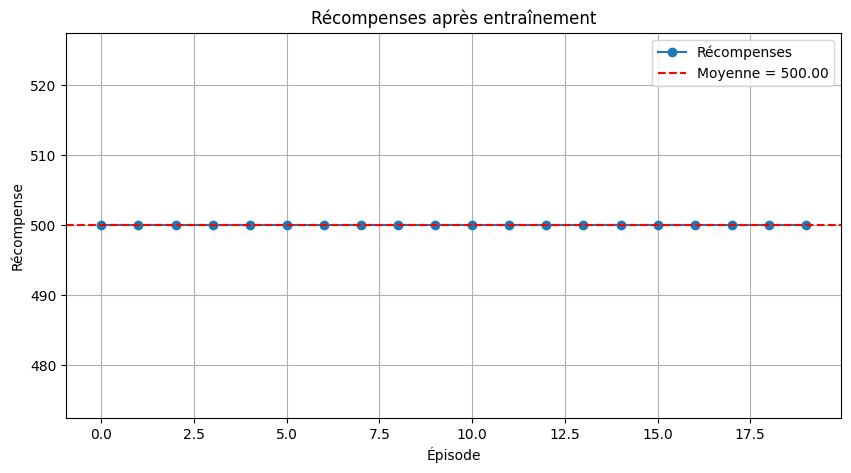

In [14]:
# Avant l'entraînement
learner_rewards_before, _ = evaluate_policy(
    learner, env, n_eval_episodes=20, return_episode_rewards=True
)
print(f"Récompenses avant entraînement : {np.mean(learner_rewards_before):.2f}")
plot_rewards(learner_rewards_before, title="Récompenses avant entraînement")

# Après l'entraînement
airl.train(N_TRAIN_STEPS)
learner_rewards_after, _ = evaluate_policy(
    learner, env, n_eval_episodes=20, return_episode_rewards=True
)
print(f"Récompenses après entraînement : {np.mean(learner_rewards_after):.2f}")
plot_rewards(learner_rewards_after, title="Récompenses après entraînement")
